In [1]:
import pandas as pd
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from contextlib import contextmanager
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import missingno

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, make_scorer

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
# from functions import read_table_from_pg 

import pickle

In [2]:
spark = (
    SparkSession.builder.config(
        "spark.jars",
        "/Library/Python/3.9/lib/python/site-packages/pyspark/jars/postgresql-42.3.1.jar",
    )
    .master("local[*]")
    .appName("parse_teams")
    .getOrCreate()
)

24/05/22 17:47:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [25]:
def save_object(obj, filepath='/nhl_project/models/'):
    """
    Сохраняет объект в файл в формате pickle.

    :param obj: Объект для сохранения.
    :param filepath: Путь к файлу, в который будет сохранен объект.
    """
    with open(filepath, 'wb') as file:
        pickle.dump(obj, file)

    print(f'Объект сохранен в {filepath}')

In [5]:
df_games = read_table_from_pg(spark, "public.games_wide_datamart")
teams_stat = read_table_from_pg(spark, "public.teams_stat_wide_datamart")
nhl_games_odds = read_table_from_pg(spark, "public.nhl_games_odds")

Started at: 2024-05-22 17:47:28.584328
Данные успешно загружены из таблицы public.games_wide_datamart PostgreSQL в Spark DataFrame.
Ended at: 2024-05-22 17:47:30.112092
Duration: 0:00:01.527764

Started at: 2024-05-22 17:47:30.112333
Данные успешно загружены из таблицы public.teams_stat_wide_datamart PostgreSQL в Spark DataFrame.
Ended at: 2024-05-22 17:47:30.376291
Duration: 0:00:00.263958

Started at: 2024-05-22 17:47:30.376381
Данные успешно загружены из таблицы public.nhl_games_odds PostgreSQL в Spark DataFrame.
Ended at: 2024-05-22 17:47:30.593250
Duration: 0:00:00.216869



In [6]:
df_games = df_games.toPandas()
teams_stat = teams_stat.toPandas()
nhl_games_odds = nhl_games_odds.toPandas()

24/05/22 17:47:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


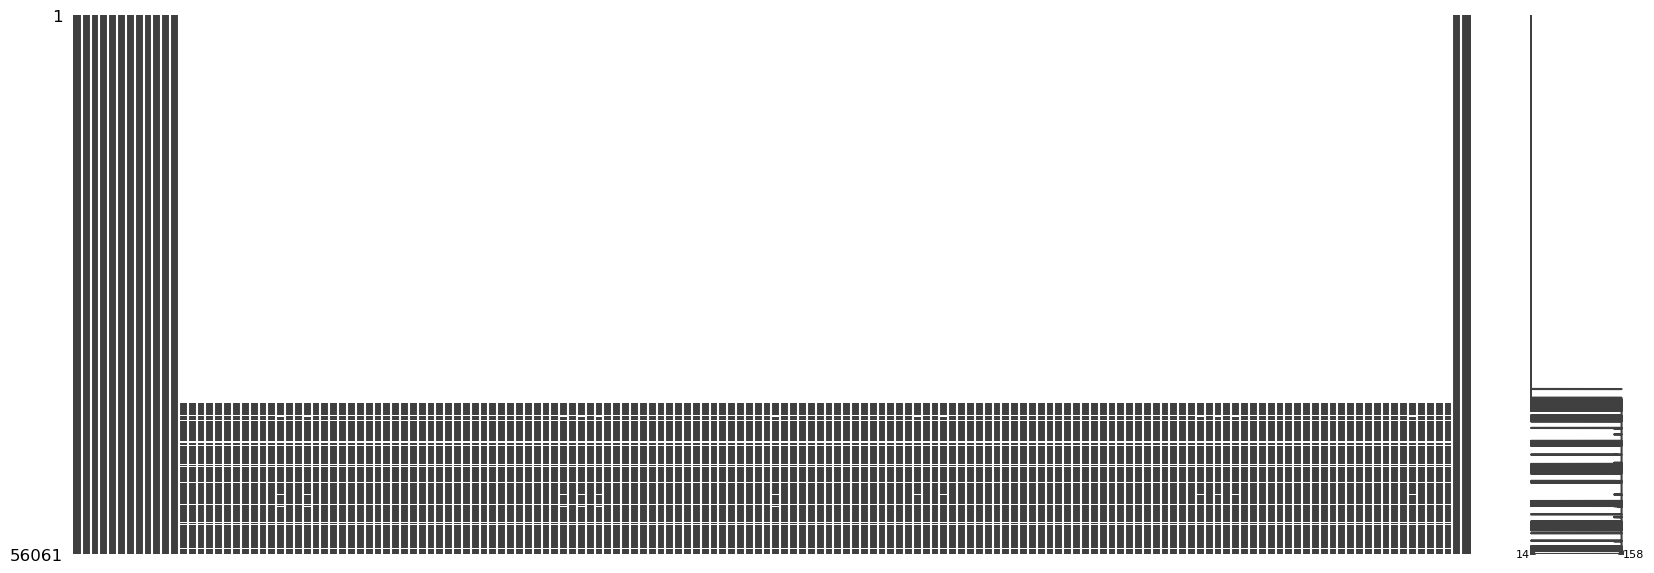

In [7]:
missingno.matrix(df_games, figsize=(20, 7), label_rotation=45, fontsize=10);

In [8]:
df_games = df_games.sort_values('eastern_start_time')

df_games['game_date'] = df_games.game_date.astype(str)

df_games['home_team_name'] = df_games['home_team_name'].replace('Phoenix Coyotes', 'Arizona Coyotes')
df_games['visiting_team_name'] = df_games['visiting_team_name'].replace('Phoenix Coyotes', 'Arizona Coyotes')

df_games['home_team_code'] = df_games['home_team_code'].replace('PHI', 'ARI')
df_games['visiting_team_code'] = df_games['visiting_team_code'].replace('PHI', 'ARI')

df_games.head()

,game_source_id,game_date,eastern_start_time,season,home_team_code,home_team_name,visiting_team_code,visiting_team_name,game_type,home_score,...,v_ties,v_waivers_sequence,v_wildcard_sequence,v_win_pctg,v_wins,v_team_name,v_conference_name,v_division_name,home_team_winner,game_month
0,1924020009,1924-12-08,1924-12-08T20:15:00,19241925,BOS,Boston Bruins,MTL,Montréal Canadiens,2,3,...,NaN,NaN,NaN,NaN,NaN,None,None,None,0,12
1,1924020023,1924-12-25,1924-12-25T20:30:00,19241925,MTL,Montréal Canadiens,BOS,Boston Bruins,2,5,...,NaN,NaN,NaN,NaN,NaN,None,None,None,1,12
2,1924020039,1925-01-10,1925-01-10T20:30:00,19241925,MTL,Montréal Canadiens,BOS,Boston Bruins,2,2,...,NaN,NaN,NaN,NaN,NaN,None,None,None,0,1
3,1924020052,1925-01-27,1925-01-27T20:15:00,19241925,BOS,Boston Bruins,MTL,Montréal Canadiens,2,0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,0,1
4,1924020069,1925-02-14,1925-02-14T20:30:00,19241925,MTL,Montréal Canadiens,BOS,Boston Bruins,2,5,...,NaN,NaN,NaN,NaN,NaN,None,None,None,1,2


#### Заполним пропуски в данных для домашних и для выездных игр

In [9]:
df_games = df_games.sort_values('eastern_start_time')

df_games['home_matches'] = df_games.groupby(['home_team_code', 'season']).cumcount()
df_games['home_wins'] = df_games.groupby(['home_team_code', 'season'])['home_team_winner'].cumsum() - df_games['home_team_winner']

df_games['h_home_wins'] = df_games['h_home_wins'].fillna(df_games['home_wins'])
df_games['h_home_games_played'] = df_games['h_home_games_played'].fillna(df_games['home_matches'])
df_games['h_home_win_pctg'] = df_games['home_wins'] / df_games['home_matches']

df_games.drop(columns=['home_matches', 'home_wins'], inplace=True)


df_games['visiting_team_winner'] = np.abs(1 - df_games['home_team_winner'])

df_games['road_matches'] = df_games.groupby(['visiting_team_code', 'season']).cumcount()
df_games['road_wins'] = df_games.groupby(['visiting_team_code', 'season'])['visiting_team_winner'].cumsum() - df_games['visiting_team_winner']

df_games['v_road_wins'] = df_games['v_road_wins'].fillna(df_games['road_wins'])
df_games['v_road_games_played'] = df_games['v_road_games_played'].fillna(df_games['road_matches'])
df_games['v_road_win_pctg'] = df_games['road_wins'] / df_games['road_matches']

df_games.drop(columns=['road_matches', 'road_wins', 'visiting_team_winner'], inplace=True)

df_games.head()

,game_source_id,game_date,eastern_start_time,season,home_team_code,home_team_name,visiting_team_code,visiting_team_name,game_type,home_score,...,v_wildcard_sequence,v_win_pctg,v_wins,v_team_name,v_conference_name,v_division_name,home_team_winner,game_month,h_home_win_pctg,v_road_win_pctg
0,1924020009,1924-12-08,1924-12-08T20:15:00,19241925,BOS,Boston Bruins,MTL,Montréal Canadiens,2,3,...,NaN,NaN,NaN,None,None,None,0,12,NaN,NaN
1,1924020023,1924-12-25,1924-12-25T20:30:00,19241925,MTL,Montréal Canadiens,BOS,Boston Bruins,2,5,...,NaN,NaN,NaN,None,None,None,1,12,NaN,NaN
2,1924020039,1925-01-10,1925-01-10T20:30:00,19241925,MTL,Montréal Canadiens,BOS,Boston Bruins,2,2,...,NaN,NaN,NaN,None,None,None,0,1,1.0,0.0
3,1924020052,1925-01-27,1925-01-27T20:15:00,19241925,BOS,Boston Bruins,MTL,Montréal Canadiens,2,0,...,NaN,NaN,NaN,None,None,None,0,1,0.0,1.0
4,1924020069,1925-02-14,1925-02-14T20:30:00,19241925,MTL,Montréal Canadiens,BOS,Boston Bruins,2,5,...,NaN,NaN,NaN,None,None,None,1,2,0.5,0.5


In [10]:
home_games = df_games[['game_date', 'season', 'home_team_code', 'home_team_winner']].rename(columns={'home_team_code': 'team_code', 'home_team_winner': 'win'})
away_games = df_games[['game_date', 'season', 'visiting_team_code']].rename(columns={'visiting_team_code': 'team_code'})
away_games['win'] = np.abs(1 - df_games['home_team_winner'])

In [11]:
all_games = pd.concat([home_games, away_games])
all_games = all_games.sort_values('game_date')


all_games['prev_cumulative_matches'] = all_games.groupby(['team_code', 'season']).cumcount()
all_games['prev_cumulative_wins'] = all_games.groupby(['team_code', 'season'])['win'].cumsum() - all_games['win']

all_games['prev_cumulative_win_pctg'] = all_games['prev_cumulative_wins'] / all_games['prev_cumulative_matches']

all_games.head()

,game_date,season,team_code,win,prev_cumulative_matches,prev_cumulative_wins,prev_cumulative_win_pctg
0,1924-12-08,19241925,BOS,0,0,0,NaN
0,1924-12-08,19241925,MTL,1,0,0,NaN
1,1924-12-25,19241925,MTL,1,1,1,1.0
1,1924-12-25,19241925,BOS,0,1,0,0.0
2,1925-01-10,19241925,MTL,0,2,2,1.0


In [12]:
df_games = (
    df_games.merge(
        all_games[
            [
                "game_date",
                "team_code",
                "prev_cumulative_win_pctg",
                "prev_cumulative_matches",
                "prev_cumulative_wins",
            ]
        ],
        left_on=["game_date", "home_team_code"],
        right_on=["game_date", "team_code"],
    )
    .rename(
        columns={
            "prev_cumulative_win_pctg": "h_wins_pctg_cumsum",
            "prev_cumulative_matches": "h_games_played_cumsum",
            "prev_cumulative_wins": "h_wins_cumsum",
        }
    )
    .drop(columns=["team_code"])
)

df_games = (
    df_games.merge(
        all_games[
            [
                "game_date",
                "team_code",
                "prev_cumulative_win_pctg",
                "prev_cumulative_matches",
                "prev_cumulative_wins",
            ]
        ],
        left_on=["game_date", "visiting_team_code"],
        right_on=["game_date", "team_code"],
    )
    .rename(
        columns={
            "prev_cumulative_win_pctg": "v_wins_pctg_cumsum",
            "prev_cumulative_matches": "v_games_played_cumsum",
            "prev_cumulative_wins": "v_wins_cumsum",
        }
    )
    .drop(columns=["team_code"])
)

df_games.head()

,game_source_id,game_date,eastern_start_time,season,home_team_code,home_team_name,visiting_team_code,visiting_team_name,game_type,home_score,...,home_team_winner,game_month,h_home_win_pctg,v_road_win_pctg,h_wins_pctg_cumsum,h_games_played_cumsum,h_wins_cumsum,v_wins_pctg_cumsum,v_games_played_cumsum,v_wins_cumsum
0,1924020009,1924-12-08,1924-12-08T20:15:00,19241925,BOS,Boston Bruins,MTL,Montréal Canadiens,2,3,...,0,12,NaN,NaN,NaN,0,0,NaN,0,0
1,1924020023,1924-12-25,1924-12-25T20:30:00,19241925,MTL,Montréal Canadiens,BOS,Boston Bruins,2,5,...,1,12,NaN,NaN,1.000000,1,1,0.000000,1,0
2,1924020039,1925-01-10,1925-01-10T20:30:00,19241925,MTL,Montréal Canadiens,BOS,Boston Bruins,2,2,...,0,1,1.0,0.0,1.000000,2,2,0.000000,2,0
3,1924020052,1925-01-27,1925-01-27T20:15:00,19241925,BOS,Boston Bruins,MTL,Montréal Canadiens,2,0,...,0,1,0.0,1.0,0.333333,3,1,0.666667,3,2
4,1924020069,1925-02-14,1925-02-14T20:30:00,19241925,MTL,Montréal Canadiens,BOS,Boston Bruins,2,5,...,1,2,0.5,0.5,0.750000,4,3,0.250000,4,1


In [13]:
df_games["h_win_pctg"] = df_games["h_win_pctg"].fillna(df_games["h_wins_pctg_cumsum"])
df_games["h_games_played"] = df_games["h_games_played"].fillna(
    df_games["h_games_played_cumsum"]
)
df_games["h_wins"] = df_games["h_wins"].fillna(df_games["h_wins_cumsum"])


df_games["v_win_pctg"] = df_games["v_win_pctg"].fillna(df_games["v_wins_pctg_cumsum"])
df_games["v_games_played"] = df_games["v_games_played"].fillna(
    df_games["v_games_played_cumsum"]
)
df_games["v_wins"] = df_games["v_wins"].fillna(df_games["v_wins_cumsum"])

df_games.drop(
    columns=[
        "h_wins_pctg_cumsum",
        "h_games_played_cumsum",
        "h_wins_cumsum",
        "v_wins_pctg_cumsum",
        "v_games_played_cumsum",
        "v_wins_cumsum",
    ],
    inplace=True,
)

In [14]:
def fill_na_by_team(group):
    return group.fillna(method='ffill').fillna(method='bfill')


columns_to_fill = sorted(df_games.columns[df_games.isna().any()].tolist())
columns_without_h = [col for col in columns_to_fill if col.startswith('h_')]
columns_without_v = [col for col in columns_to_fill if col.startswith('v_')]

df_games[columns_without_h] = df_games.groupby('home_team_code')[columns_without_h].transform(fill_na_by_team)
df_games[columns_without_v] = df_games.groupby('visiting_team_code')[columns_without_v].transform(fill_na_by_team)

In [15]:
df_games = df_games[(df_games.game_date >= '2012-01-01')]

df_games['h_avg_home_goals_for'] = df_games['h_home_goals_for'] / df_games['h_home_games_played']
df_games['v_avg_road_goals_against'] = df_games['v_road_goals_against'] / df_games['v_road_games_played']

df_games['v_avg_road_goals_for'] = df_games['v_road_goals_for'] / df_games['v_road_games_played']
df_games['h_avg_home_goals_against'] = df_games['h_home_goals_against'] / df_games['h_home_games_played']

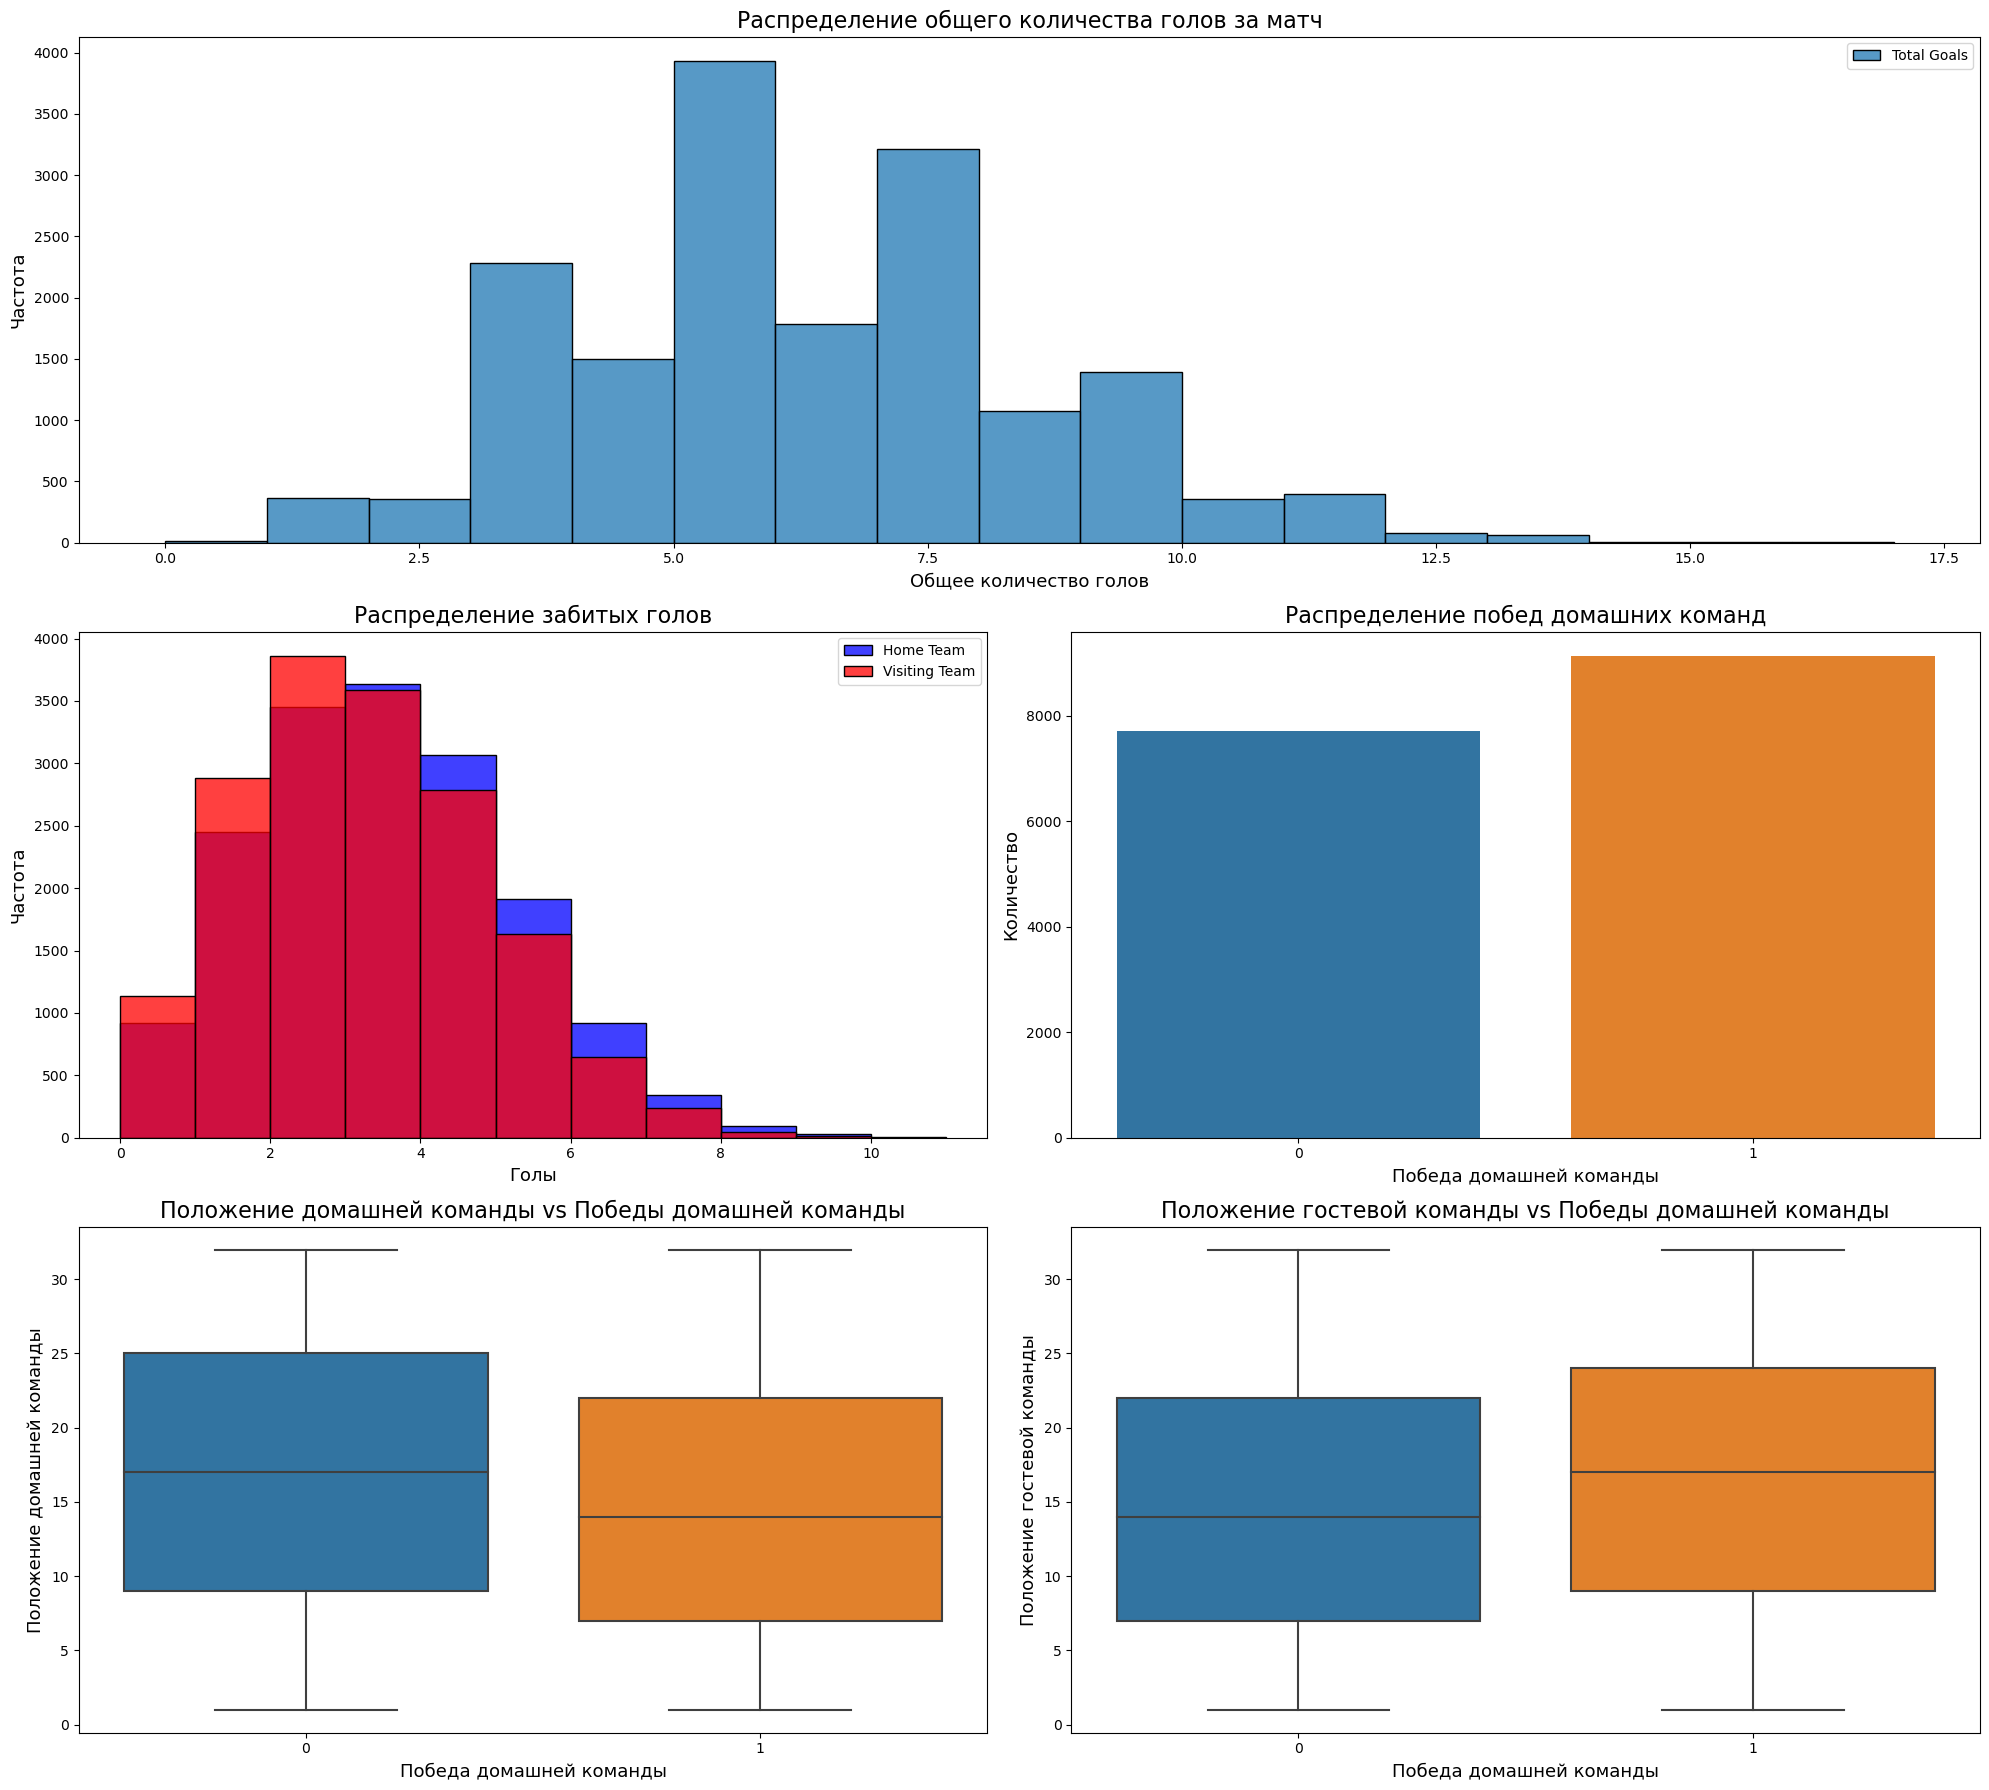

In [16]:
fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(3, 2)

ax0 = plt.subplot(gs[0, :])
df_games['total_goals'] = df_games['home_score'] + df_games['visiting_score']
sns.histplot(data=df_games, x='total_goals', bins=range(df_games['total_goals'].max() + 1), 
             label='Total Goals', ax=ax0)
ax0.set_title('Распределение общего количества голов за матч', fontsize=16)
ax0.set_xlabel('Общее количество голов', fontsize=13)
ax0.set_ylabel('Частота', fontsize=13)
ax0.legend()

ax1 = plt.subplot(gs[1, 0])
sns.histplot(data=df_games, x='home_score', bins=11, color='blue', label='Home Team', ax=ax1)
sns.histplot(data=df_games, x='visiting_score', bins=10, color='red', label='Visiting Team', ax=ax1)
ax1.set_title('Распределение забитых голов', fontsize=16)
ax1.set_xlabel('Голы', fontsize=13)
ax1.set_ylabel('Частота', fontsize=13)
ax1.legend()

ax2 = plt.subplot(gs[1, 1])
sns.countplot(data=df_games, x='home_team_winner', ax=ax2)
ax2.set_title('Распределение побед домашних команд', fontsize=16)
ax2.set_xlabel('Победа домашней команды', fontsize=13)
ax2.set_ylabel('Количество', fontsize=13)

ax3 = plt.subplot(gs[2, 0])
sns.boxplot(data=df_games, x='home_team_winner', y='h_league_sequence', ax=ax3)
ax3.set_title('Положение домашней команды vs Победы домашней команды', fontsize=16)
ax3.set_xlabel('Победа домашней команды', fontsize=13)
ax3.set_ylabel('Положение домашней команды', fontsize=13)

ax4 = plt.subplot(gs[2, 1])
sns.boxplot(data=df_games, x='home_team_winner', y='v_league_sequence', ax=ax4)
ax4.set_title('Положение гостевой команды vs Победы домашней команды', fontsize=16)
ax4.set_xlabel('Победа домашней команды', fontsize=13)
ax4.set_ylabel('Положение гостевой команды', fontsize=13)

plt.tight_layout()
plt.show()

**Выводы:**
* Большинство игр заканчивается с количеством голов в диапазоне от 4 до 7. 
* Данные показывают, что домашние команды (синий цвет) забивают голы чаще, чем гостевые команды (красный цвет), что может указывать на домашнее преимущество.
* Явно видна тенденция домашних команд к победе в матчах 
* Распределение показывает, что положение команды в лиге не имеет явного влияния на исход матча (победы или поражения домашней команды). Размах и медиана величины h_conference_home_sequence схожи как для побед, так и для поражений.
* Похоже, что также нет сильной зависимости между положением гостевой команды в своей конференции и исходом игры для домашней команды.

In [17]:
fig = go.Figure()

teams_stat = teams_stat.sort_values('date')

selected_season = 20212022
default_teams = ['BOS', 'SJS', 'CAR', 'CGY']
all_teams = sorted(teams_stat['team_business_id'].unique())

for team in all_teams:
    team_data = teams_stat[(teams_stat['season_id'] >= selected_season) & (teams_stat['team_business_id'] == team)]
    fig.add_trace(go.Scatter(
        x=team_data['date'],
        y=team_data['win_pctg'],
        name=team,
        visible='legendonly' if team not in default_teams else True
    ))

fig.update_layout(
    title='Изменение процента побед команд',
    xaxis_title='Дата игры',
    yaxis_title='Процент побед',
    width=1300,
    height=600
)

fig.show()


In [18]:
nhl_games_odds.tail()

,eastern_dt,game_date,home_team_name,visiting_team_name,win_home_team,draw,win_visiting_team
17603,2024-05-18T18:00:00,2024-05-18,Edmonton Oilers,Vancouver Canucks,1.86,4.35,3.43
17604,2024-05-20T19:00:00,2024-05-20,Vancouver Canucks,Edmonton Oilers,2.95,4.11,2.09
17605,2024-05-22T18:00:00,2024-05-22,New York Rangers,Florida Panthers,2.54,4.05,2.40
17606,2024-05-23T18:30:00,2024-05-23,Dallas Stars,Edmonton Oilers,2.24,4.14,2.70
17607,2024-05-28T18:00:00,2024-05-28,Florida Panthers,New York Rangers,NaN,NaN,NaN


In [19]:
games_merged = (
    pd.merge(
        df_games,
        nhl_games_odds,
        on=["home_team_name", "game_date", "visiting_team_name"],
        how="inner",
    )
    .sort_values(by="game_date")
    .fillna(0)
)
games_merged.drop(columns=["eastern_dt"], inplace=True)

games_merged.tail()

,game_source_id,game_date,eastern_start_time,season,home_team_code,home_team_name,visiting_team_code,visiting_team_name,game_type,home_score,...,h_home_win_pctg,v_road_win_pctg,h_avg_home_goals_for,v_avg_road_goals_against,v_avg_road_goals_for,h_avg_home_goals_against,total_goals,win_home_team,draw,win_visiting_team
16820,2023030246,2024-05-18,2024-05-18T20:00:00,20232024,EDM,Edmonton Oilers,VAN,Vancouver Canucks,3,5,...,0.673913,0.586957,3.500000,2.608696,2.891304,2.260870,6,1.86,4.35,3.43
16821,2023030247,2024-05-20,2024-05-20T21:00:00,20232024,VAN,Vancouver Canucks,EDM,Edmonton Oilers,3,2,...,0.638298,0.521739,2.978723,2.739130,2.673913,2.085106,5,2.95,4.11,2.09
16822,2023030311,2024-05-22,2024-05-22T20:00:00,20232024,NYR,New York Rangers,FLA,Florida Panthers,3,0,...,0.739130,0.652174,3.000000,2.000000,2.978261,2.391304,0,2.54,4.05,2.40
16823,2023030321,2024-05-23,2024-05-23T20:30:00,20232024,DAL,Dallas Stars,EDM,Edmonton Oilers,3,0,...,0.604167,0.531915,3.187500,2.680851,2.617021,2.562500,0,2.24,4.14,2.70
16824,2023030314,2024-05-28,2024-05-28T20:00:00,20232024,FLA,Florida Panthers,NYR,New York Rangers,3,0,...,0.645833,0.617021,2.583333,2.446809,2.936170,2.145833,0,0.00,0.00,0.00


In [20]:
numeric_cols = games_merged.select_dtypes(include=[np.number]).columns

In [21]:
print("Проверка на бесконечные значения и NaN:")
print(np.isinf(games_merged[numeric_cols]).sum())
print(np.isnan(games_merged[numeric_cols]).sum())

Проверка на бесконечные значения и NaN:
game_source_id               0
season                       0
game_type                    0
home_score                   0
visiting_score               0
                            ..
h_avg_home_goals_against    51
total_goals                  0
win_home_team                0
draw                         0
win_visiting_team            0
Length: 154, dtype: int64
game_source_id              0
season                      0
game_type                   0
home_score                  0
visiting_score              0
                           ..
h_avg_home_goals_against    0
total_goals                 0
win_home_team               0
draw                        0
win_visiting_team           0
Length: 154, dtype: int64


In [22]:
games_merged[numeric_cols] = games_merged[numeric_cols].replace([np.inf, -np.inf], np.nan)
games_merged[numeric_cols] = games_merged[numeric_cols].fillna(games_merged[numeric_cols].mean())

In [26]:
save_object(games_merged, '/Users/shiryaevva/HSE/2-nd_year/nhl-ml-project/nhl_project/data/processed/model_dataset.pkl')

Объект сохранен в /Users/shiryaevva/HSE/2-nd_year/nhl-ml-project/nhl_project/data/processed/model_dataset.pkl


## Разделим данные на train и test

In [27]:
games_merged_drop = games_merged.sort_values(by="game_date").drop(
    columns=[
        "game_source_id",
        "eastern_start_time",
        "game_date",
        "game_type",
        "score_delta",
        "home_team_name",
        "visiting_team_name",
        "home_score",
        "visiting_score",
        "total_goals",
        "v_team_name",
        "h_team_name",
    ]
)

test_index = int(0.06 * len(games_merged_drop))

df_train = games_merged_drop.iloc[:-test_index]
df_test = games_merged_drop.iloc[-test_index:]

X_train = df_train.drop(columns=["home_team_winner"])
y_train = df_train.home_team_winner

X_test = df_test.drop(columns=["home_team_winner"])
y_test = df_test.home_team_winner

X_train.tail()

,season,home_team_code,visiting_team_code,h_conference_home_sequence,h_conference_l10_sequence,h_conference_road_sequence,h_conference_sequence,h_division_home_sequence,h_division_l10_sequence,h_division_road_sequence,...,game_month,h_home_win_pctg,v_road_win_pctg,h_avg_home_goals_for,v_avg_road_goals_against,v_avg_road_goals_for,h_avg_home_goals_against,win_home_team,draw,win_visiting_team
15811,20232024,DAL,DET,10.0,11.0,3.0,6.0,6.0,6.0,1.0,...,12,0.500000,0.545455,3.500000,3.181818,3.727273,3.583333,1.76,4.58,3.73
15812,20232024,COL,CGY,3.0,7.0,6.0,5.0,1.0,3.0,3.0,...,12,0.692308,0.357143,4.000000,3.714286,2.857143,2.846154,1.94,4.42,3.19
15817,20232024,NSH,ARI,4.0,5.0,9.0,7.0,2.0,2.0,5.0,...,12,0.600000,0.482759,3.200000,2.357143,3.357143,2.933333,2.16,4.24,2.80
15818,20232024,OTT,CAR,10.0,8.0,16.0,16.0,6.0,4.0,8.0,...,12,0.500000,0.375000,3.437500,3.625000,3.000000,3.250000,2.74,4.36,2.18
15813,20232024,NYR,TOR,5.0,3.0,1.0,1.0,2.0,2.0,1.0,...,12,0.818182,0.500000,3.545455,2.750000,3.000000,2.727273,1.90,4.41,3.26


In [28]:
categorical_features = [
    "season",
    "home_team_code",
    "visiting_team_code",
    "h_conference_name",
    "h_division_name",
    "h_streak_code",
    "v_conference_name",
    "v_division_name",
    "v_streak_code",
    "game_month",
]

numeric_features = (
    X_train.drop(columns=categorical_features)
    .select_dtypes(include=["int64", "float64"])
    .columns.tolist()
)

## Обучим модель предсказывать какая команды победит
#### Домашняя команда - 1, команда на выезде - 0

### Baseline - Random
В качестве первого бейзлайна возьмем рандомный прогноз, чтобы увидеть, насколько наша модель будет лучше случайного угадывания.

    Baseline - Random Test
Accuracy: 0.4836471754212091
Precision: 0.5263157894736842
Recall: 0.5100182149362478
F1 score: 0.5180388529139686
ROC AUC: 0.48109606398986304


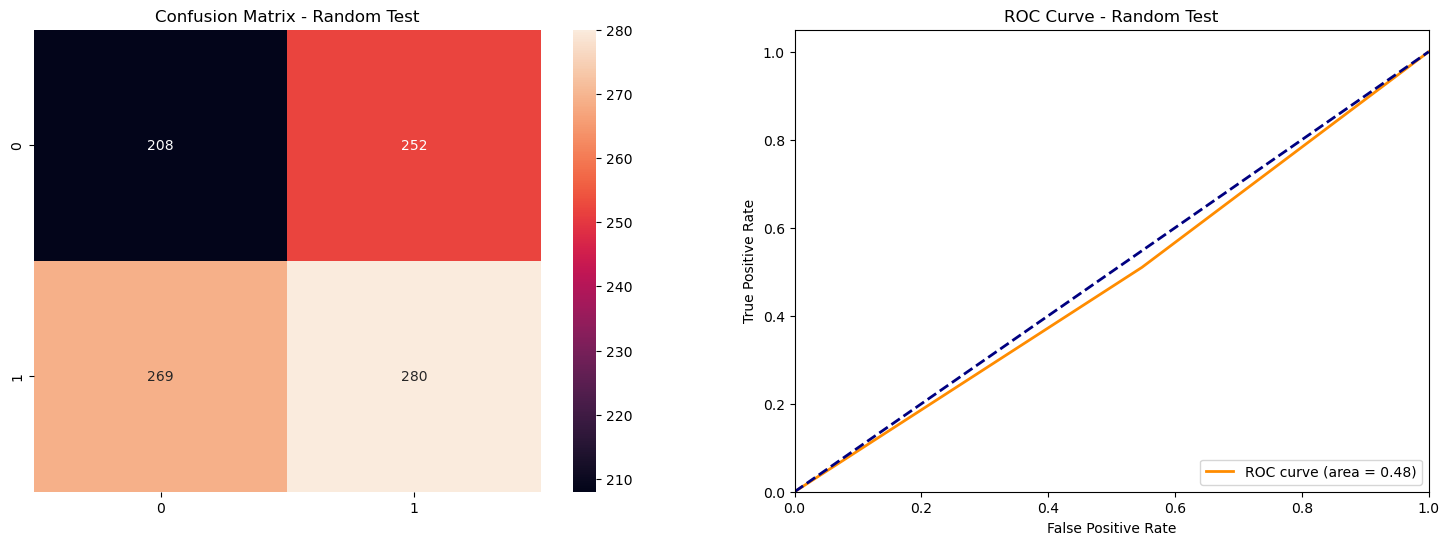

In [29]:
np.random.seed(15)

y_pred_random = np.random.randint(2, size=len(X_test))

accuracy = accuracy_score(y_test, y_pred_random)
precision = precision_score(y_test, y_pred_random)
recall = recall_score(y_test, y_pred_random)
f1 = f1_score(y_test, y_pred_random)
auc_score = roc_auc_score(y_test, y_pred_random)

print('=' * 30)
print('    Baseline - Random Test')
print('=' * 30)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')
print(f'ROC AUC: {auc_score}')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

cm = confusion_matrix(y_test, y_pred_random)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Confusion Matrix - Random Test')

fpr, tpr, _ = roc_curve(y_test, y_pred_random)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Random Test')
axes[1].legend(loc="lower right")

plt.show()

In [30]:
score_dict = {
    'model': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'roc_auc': [],
    'threshold': []
}

score_dict['model'].append('Baseline - Random')
score_dict['accuracy'].append(accuracy)
score_dict['precision'].append(precision)
score_dict['recall'].append(recall)
score_dict['f1_score'].append(f1)
score_dict['roc_auc'].append(auc_score)
score_dict['threshold'].append(None)

score_dict

{'model': ['Baseline - Random'],
 'accuracy': [0.4836471754212091],
 'precision': [0.5263157894736842],
 'recall': [0.5100182149362478],
 'f1_score': [0.5180388529139686],
 'roc_auc': [0.48109606398986304],
 'threshold': [None]}

### LogisticRegression

In [31]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline_lg = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=10000, penalty='l1', C=0.1, solver='saga', random_state=17))])

pipeline_lg.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['h_conference_home_sequence',
                                                   'h_conference_l10_sequence',
                                                   'h_conference_road_sequence',
                                                   'h_conference_sequence',
                                                   'h_division_home_sequence',
                                                   'h_division_l10_sequence',
                                                   'h_division_road_sequence',
                                                   'h_division_sequence',
                                                   'h_game_type_id',
                                                   'h_games_played',
                                                   'h_goal_differe...
                                                   'h_l10_goals_for', ...]),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['season', 'home_team_code',
                                                   'visiting_team_code',
                                                   'h_conference_name',
                                                   'h_division_name',
                                                   'h_streak_code',
                                                   'v_conference_name',
                                                   'v_division_name',
                                                   'v_streak_code',
                                                   'game_month'])])),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=10000, penalty='l1',
                                    random_state=17, solver='saga'))])

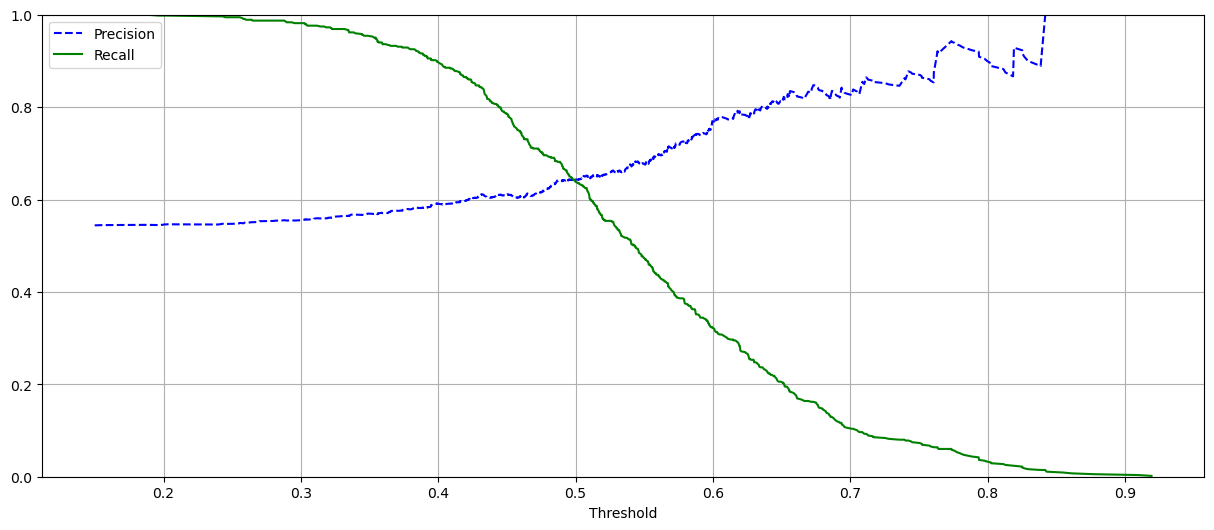

In [32]:
y_proba_lg = pipeline_lg.predict_proba(X_test)
y_proba_win_lg = y_proba_lg[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_win_lg)

plt.figure(figsize=(15, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.grid()
plt.show()

  Logistic Regression Test
Accuracy: 0.6105054509415263
Precision: 0.6433823529411765
Recall: 0.6375227686703097
F1 score: 0.6404391582799634
ROC AUC: 0.6078918191177636


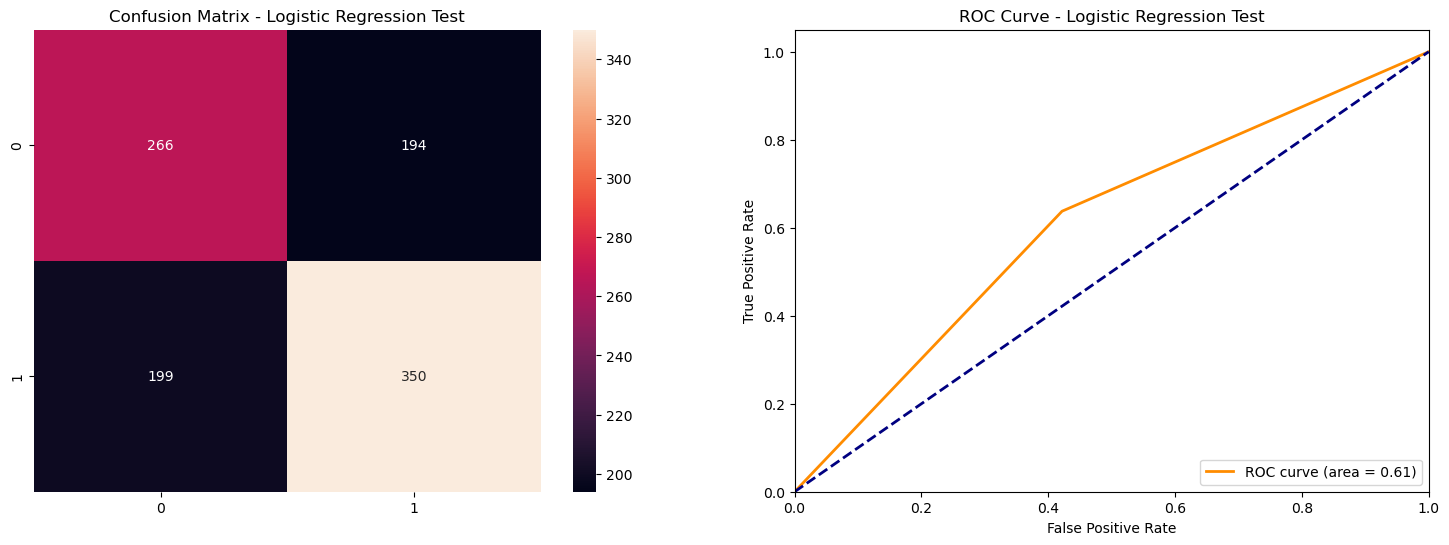

In [33]:
threshold = 0.5

y_pred = np.where(y_proba_win_lg >= threshold, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print('=' * 30)
print('  Logistic Regression Test')
print('=' * 30)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')
print(f'ROC AUC: {auc_score}')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Confusion Matrix - Logistic Regression Test')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Logistic Regression Test')
axes[1].legend(loc="lower right")

plt.show()

In [34]:
score_dict['model'].append('Logistic Regression')
score_dict['accuracy'].append(accuracy)
score_dict['precision'].append(precision)
score_dict['recall'].append(recall)
score_dict['f1_score'].append(f1)
score_dict['roc_auc'].append(auc_score)
score_dict['threshold'].append(threshold)

score_dict

{'model': ['Baseline - Random', 'Logistic Regression'],
 'accuracy': [0.4836471754212091, 0.6105054509415263],
 'precision': [0.5263157894736842, 0.6433823529411765],
 'recall': [0.5100182149362478, 0.6375227686703097],
 'f1_score': [0.5180388529139686, 0.6404391582799634],
 'roc_auc': [0.48109606398986304, 0.6078918191177636],
 'threshold': [None, 0.5]}

### SVM

In [35]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=17))
])

pipeline_svc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['h_conference_home_sequence',
                                                   'h_conference_l10_sequence',
                                                   'h_conference_road_sequence',
                                                   'h_conference_sequence',
                                                   'h_division_home_sequence',
                                                   'h_division_l10_sequence',
                                                   'h_division_road_sequence',
                                                   'h_division_sequence',
                                                   'h_game_type_id',
                                                   'h_games_played',
                                                   'h_goal_differe...
                                                   'h_l10_goal_differential',
                                                   'h_l10_goals_against',
                                                   'h_l10_goals_for', ...]),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['season', 'home_team_code',
                                                   'visiting_team_code',
                                                   'h_conference_name',
                                                   'h_division_name',
                                                   'h_streak_code',
                                                   'v_conference_name',
                                                   'v_division_name',
                                                   'v_streak_code',
                                                   'game_month'])])),
                ('classifier', SVC(probability=True, random_state=17))])

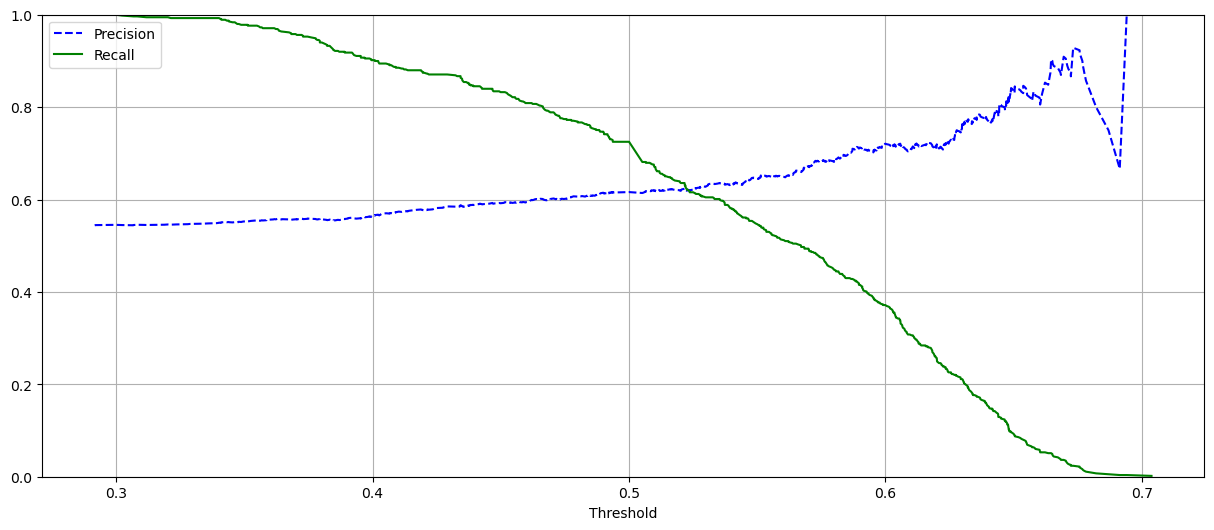

In [36]:
y_proba_svc = pipeline_svc.predict_proba(X_test)
y_proba_win_svc = y_proba_svc[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_win_svc)

plt.figure(figsize=(15, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0, 1])
plt.grid()
plt.show()

          SVM Test
Accuracy: 0.5887016848364718
Precision: 0.6187943262411347
Recall: 0.6357012750455373
F1 score: 0.6271338724168913
ROC AUC: 0.5841549853488556


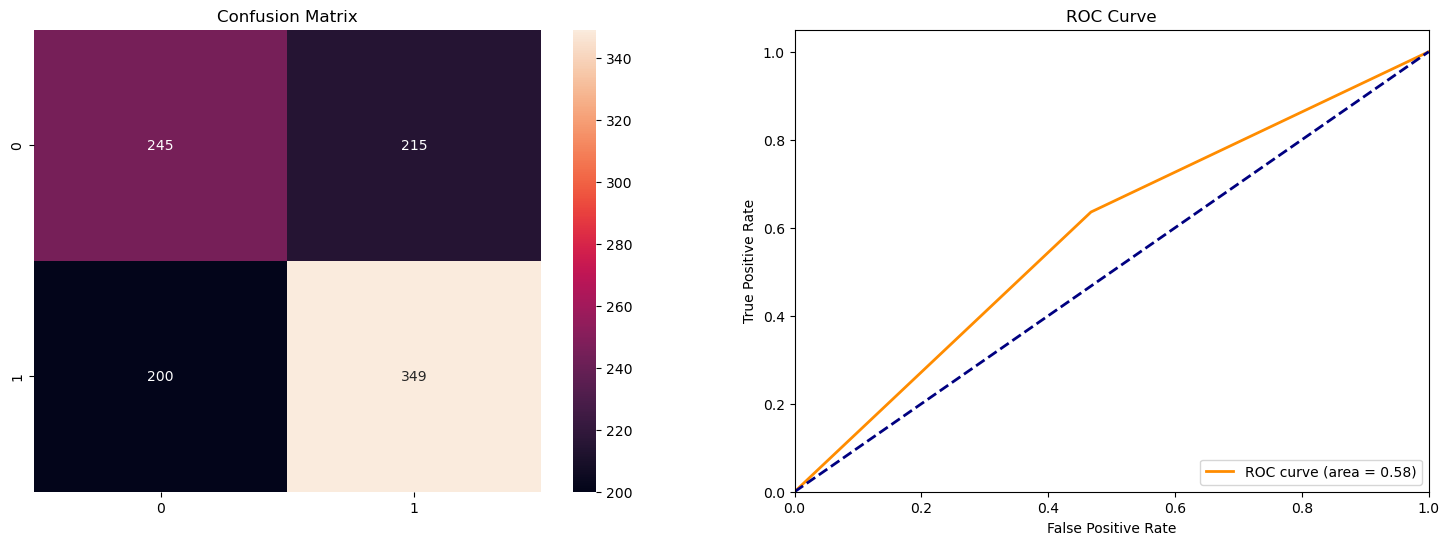

In [37]:
threshold = 0.52

y_pred = np.where(y_proba_win_svc >= threshold, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print('=' * 30)
print('          SVM Test')
print('=' * 30)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')
print(f'ROC AUC: {auc_score}')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Confusion Matrix')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")

plt.show()

In [38]:
score_dict['model'].append('SVC')
score_dict['accuracy'].append(accuracy)
score_dict['precision'].append(precision)
score_dict['recall'].append(recall)
score_dict['f1_score'].append(f1)
score_dict['roc_auc'].append(auc_score)
score_dict['threshold'].append(threshold)

score_dict

{'model': ['Baseline - Random', 'Logistic Regression', 'SVC'],
 'accuracy': [0.4836471754212091, 0.6105054509415263, 0.5887016848364718],
 'precision': [0.5263157894736842, 0.6433823529411765, 0.6187943262411347],
 'recall': [0.5100182149362478, 0.6375227686703097, 0.6357012750455373],
 'f1_score': [0.5180388529139686, 0.6404391582799634, 0.6271338724168913],
 'roc_auc': [0.48109606398986304, 0.6078918191177636, 0.5841549853488556],
 'threshold': [None, 0.5, 0.52]}

### CatBoostClassifier

In [39]:
catboost_cl = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.005,
    random_state=17,
    depth=6,
    l2_leaf_reg=7,
    cat_features=categorical_features,
)

catboost_cl.fit(X_train, y_train, verbose=500)

0:	learn: 0.6929041	total: 75.6ms	remaining: 6m 17s
500:	learn: 0.6589060	total: 7.37s	remaining: 1m 6s
1000:	learn: 0.6490545	total: 14.6s	remaining: 58.3s
1500:	learn: 0.6402649	total: 21.9s	remaining: 51.1s
2000:	learn: 0.6290839	total: 29.3s	remaining: 43.8s
2500:	learn: 0.6153673	total: 36.6s	remaining: 36.6s
3000:	learn: 0.6035802	total: 44.2s	remaining: 29.5s
3500:	learn: 0.5925941	total: 51.7s	remaining: 22.1s
4000:	learn: 0.5821689	total: 59.2s	remaining: 14.8s
4500:	learn: 0.5726881	total: 1m 6s	remaining: 7.38s
4999:	learn: 0.5632663	total: 1m 13s	remaining: 0us


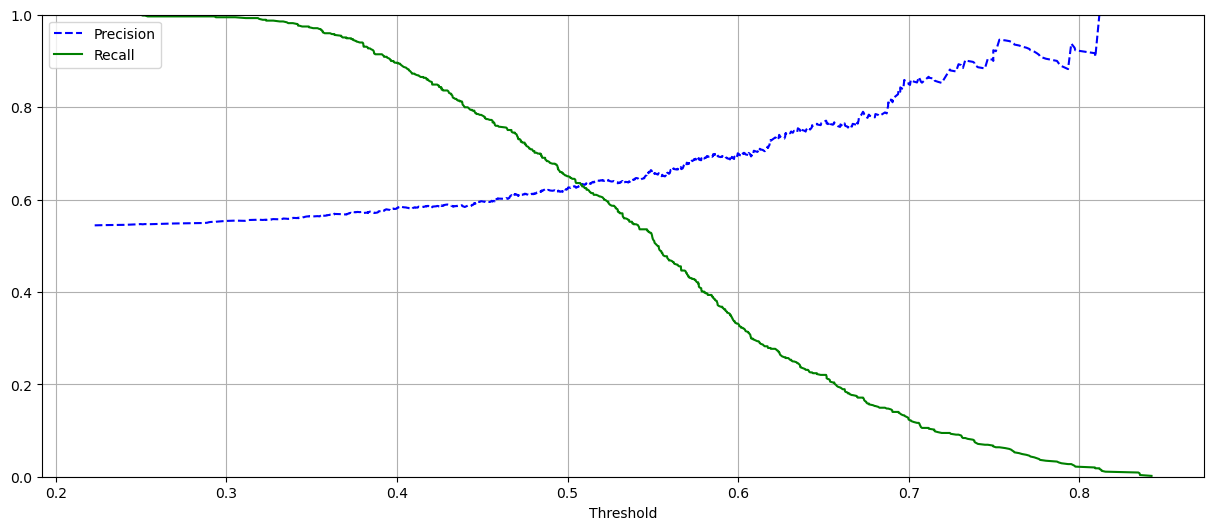

In [40]:
y_proba_catboost = catboost_cl.predict_proba(X_test)
y_proba_win_catboost = y_proba_catboost[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_win_catboost)

plt.figure(figsize=(15, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.grid()
plt.show()

  CatBoost Classifier Test
Accuracy: 0.5966303270564915
Precision: 0.6241258741258742
Recall: 0.6502732240437158
F1 score: 0.6369313113291702
ROC AUC: 0.5914409598479449


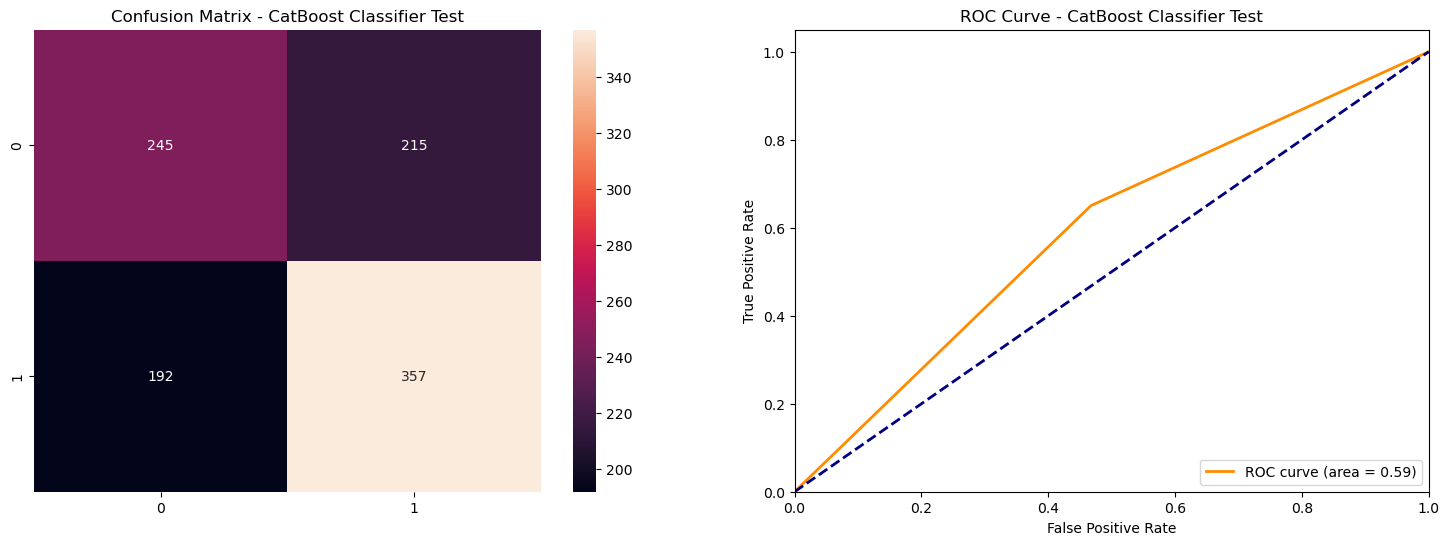

In [41]:
threshold = 0.5

y_pred = np.where(y_proba_win_catboost >= threshold, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print('=' * 30)
print('  CatBoost Classifier Test')
print('=' * 30)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')
print(f'ROC AUC: {auc_score}')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Confusion Matrix - CatBoost Classifier Test')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - CatBoost Classifier Test')
axes[1].legend(loc="lower right")

plt.show()

In [42]:
score_dict['model'].append('CatBoost Classifier')
score_dict['accuracy'].append(accuracy)
score_dict['precision'].append(precision)
score_dict['recall'].append(recall)
score_dict['f1_score'].append(f1)
score_dict['roc_auc'].append(auc_score)
score_dict['threshold'].append(threshold)

In [43]:
def plot_feature_importance(model, X, size=(20, 30)):
    model_importances = pd.DataFrame(model.feature_importances_, columns=['feature_importance'], index=X.columns)
    
    fig = plt.figure(figsize = size)
    sns.set_style('white')
    ax = sns.barplot(x='feature_importance', 
                y=model_importances.index, 
                data=model_importances, 
                order=model_importances.sort_values(by='feature_importance', ascending=False).index);

    for rect in ax.patches:
        ax.text(rect.get_width() + 0.001, rect.get_y() + rect.get_height() / 2, 
                round(rect.get_width(), 3), verticalalignment='center', fontsize = 11)

    plt.xlabel('Feature importance', fontsize=16);
    plt.ylabel('Feature', fontsize=16);
    
    return model_importances

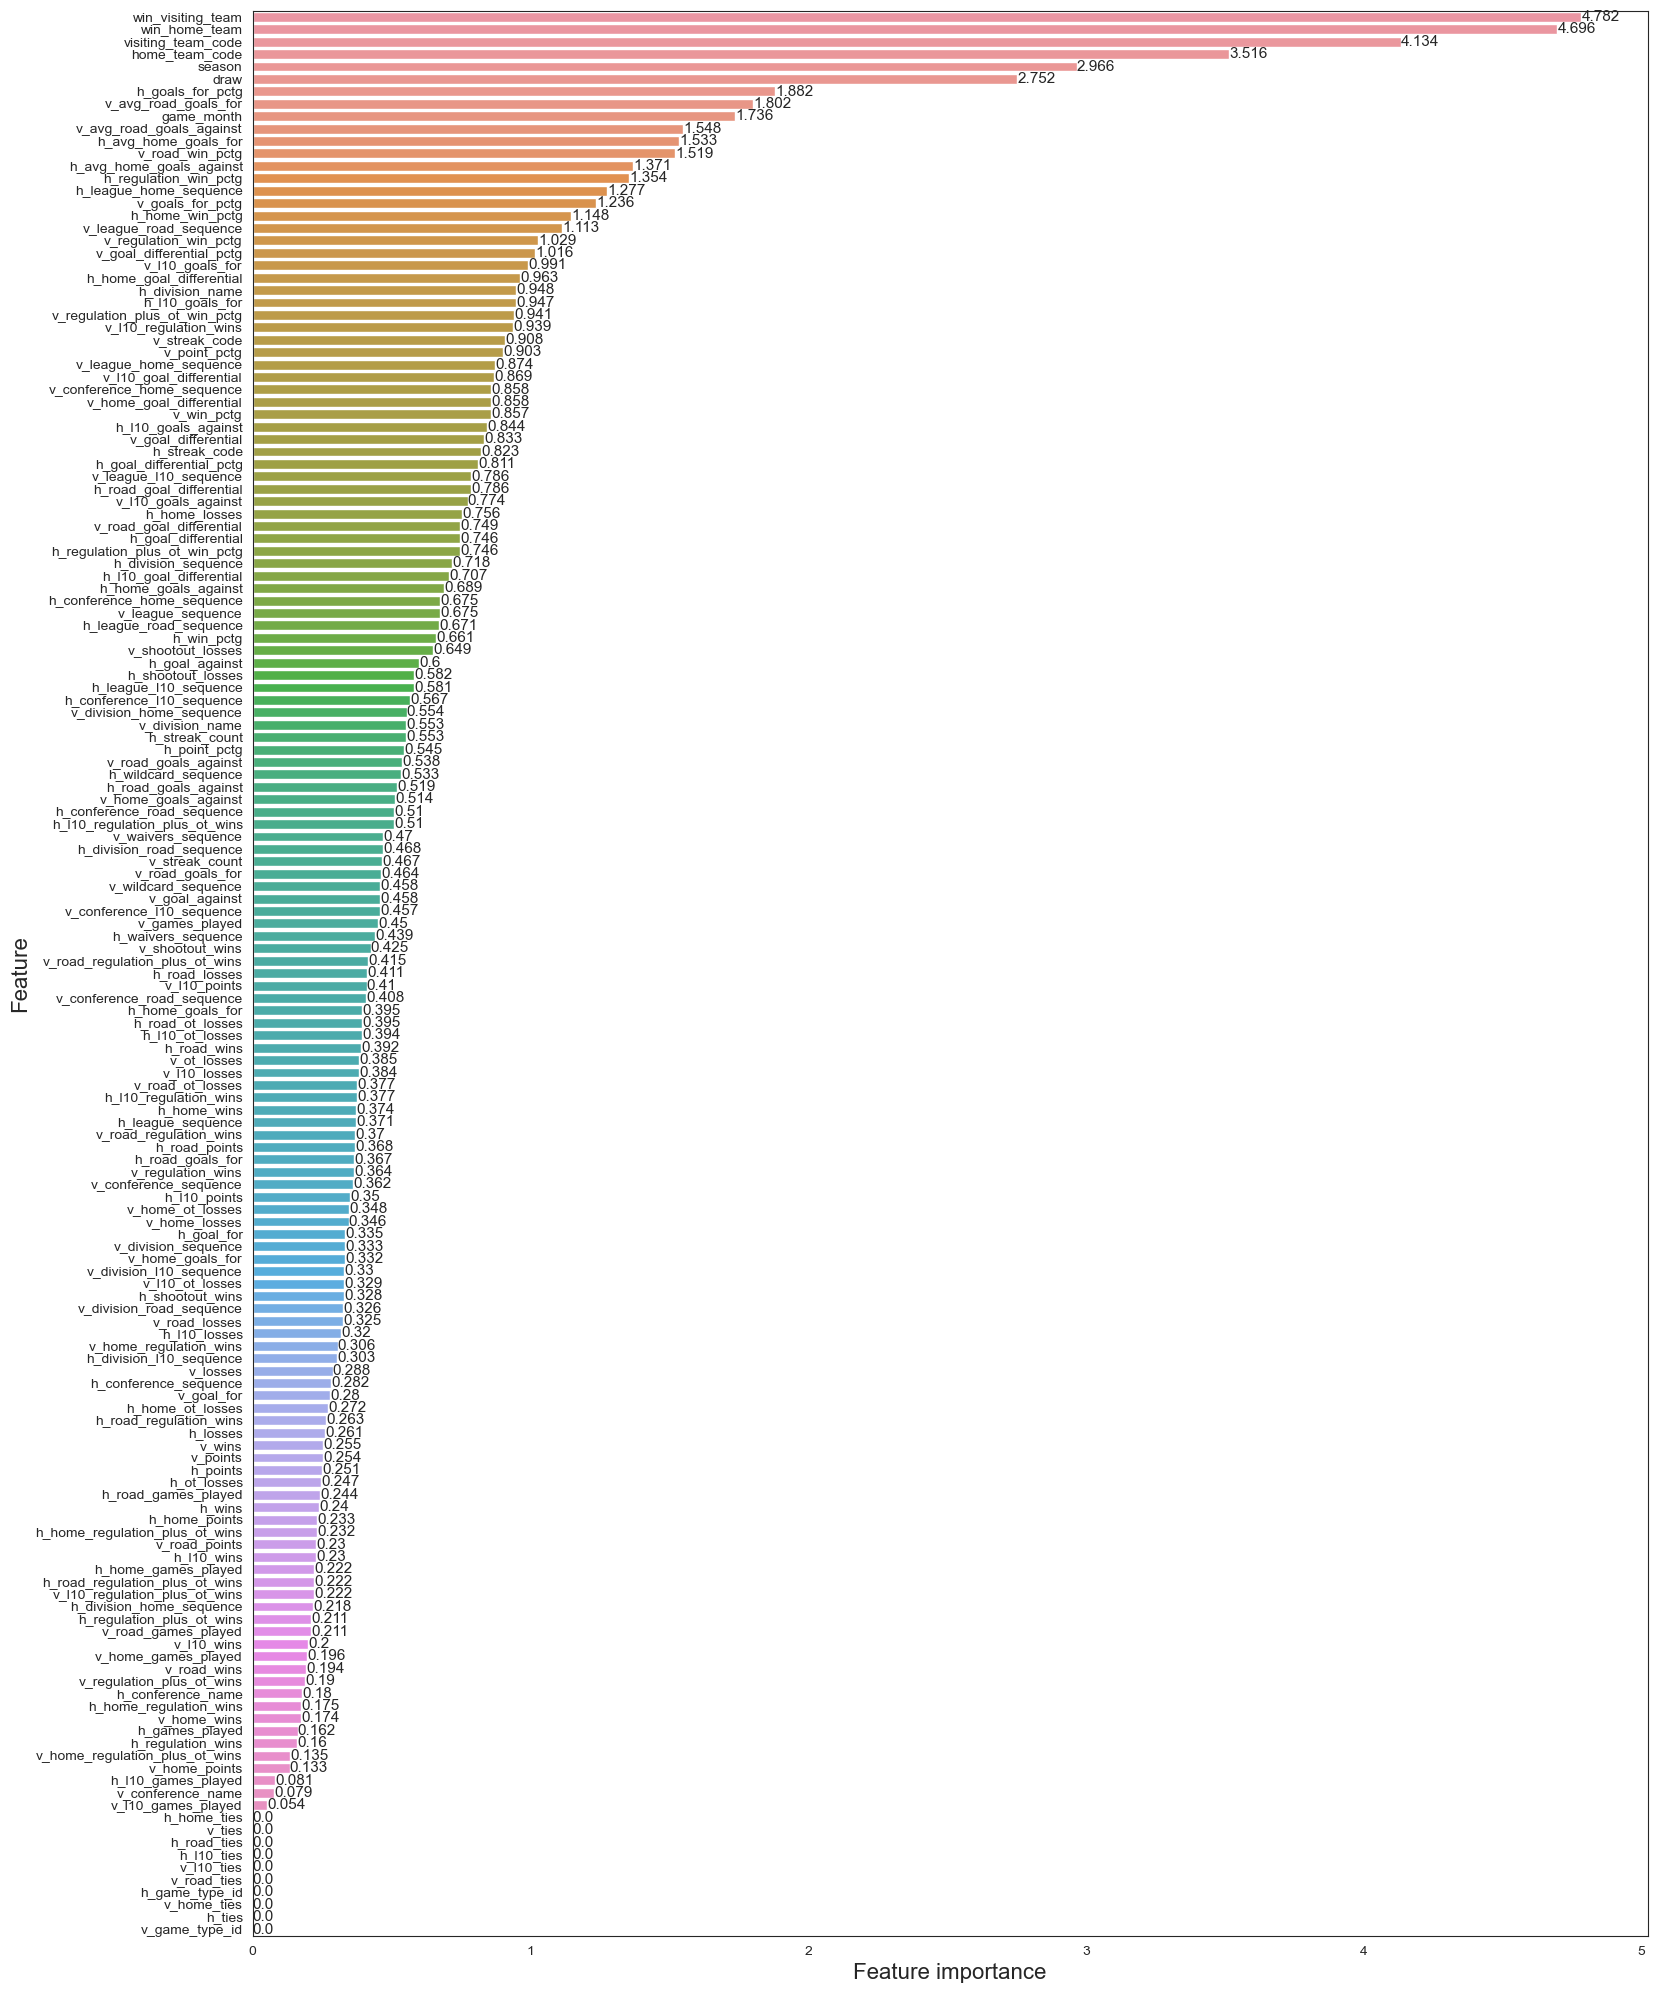

In [44]:
catboost_cl_importance = plot_feature_importance(catboost_cl, X_train, (18, 25))

## Отберем признаки

In [45]:
top_features = list(
    catboost_cl_importance.sort_values("feature_importance", ascending=False)
    .reset_index()
    .rename(columns={"index": "feature"})
    .head(80)
    .feature
)

In [46]:
X_train_top = df_train[top_features]
X_test_top = df_test[top_features]

X_train_top.tail()

,win_visiting_team,win_home_team,visiting_team_code,home_team_code,season,draw,h_goals_for_pctg,v_avg_road_goals_for,game_month,v_avg_road_goals_against,...,v_wildcard_sequence,v_goal_against,v_conference_l10_sequence,v_games_played,h_waivers_sequence,v_shootout_wins,v_road_regulation_plus_ot_wins,h_road_losses,v_l10_points,v_conference_road_sequence
15811,3.73,1.76,DET,DAL,20232024,4.58,3.423077,3.727273,12,3.181818,...,1.0,82.0,5.0,26.0,24.0,0.0,6.0,3.0,13.0,12.0
15812,3.19,1.94,CGY,COL,20232024,4.42,3.481481,2.857143,12,3.714286,...,5.0,93.0,12.0,27.0,23.0,0.0,5.0,5.0,10.0,11.0
15817,2.80,2.16,ARI,NSH,20232024,4.24,3.107143,3.357143,12,2.357143,...,0.0,73.0,6.0,27.0,16.0,2.0,7.0,7.0,13.0,2.0
15818,2.18,2.74,CAR,OTT,20232024,4.36,3.545455,3.000000,12,3.625000,...,5.0,90.0,12.0,27.0,13.0,1.0,5.0,3.0,9.0,14.0
15813,3.26,1.90,TOR,NYR,20232024,4.41,3.307692,3.000000,12,2.750000,...,0.0,81.0,2.0,25.0,32.0,4.0,6.0,4.0,15.0,6.0


In [47]:
categorical_features_top = [
    "season",
    "home_team_code",
    "visiting_team_code",
    "h_division_name",
    "h_streak_code",
    "v_division_name",
    "v_streak_code",
    "game_month",
]

numeric_features_top = (
    X_train_top.drop(columns=categorical_features_top)
    .select_dtypes(include=["int64", "float64"])
    .columns.tolist()
)

In [48]:
save_object(top_features, '/Users/shiryaevva/HSE/2-nd_year/nhl-ml-project/nhl_project/data/processed/top_features.pkl')

Объект сохранен в /Users/shiryaevva/HSE/2-nd_year/nhl-ml-project/nhl_project/data/processed/top_features.pkl


### Logistic Regression Top

In [49]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_top),
        ("cat", categorical_transformer, categorical_features_top),
    ]
)

pipeline_lg_top = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=10000, penalty='l1', C=0.1, solver='saga', random_state=17)),
    ]
)

pipeline_lg_top.fit(X_train_top, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['win_visiting_team',
                                                   'win_home_team', 'draw',
                                                   'h_goals_for_pctg',
                                                   'v_avg_road_goals_for',
                                                   'v_avg_road_goals_against',
                                                   'h_avg_home_goals_for',
                                                   'v_road_win_pctg',
                                                   'h_avg_home_goals_against',
                                                   'h_regulation_win_pctg',
                                                   'h_league_home_sequence',
                                                   'v_goals_for_pctg',
                                                   'h_home_win_p...
                                                   'h_l10_goals_against',
                                                   'v_goal_differential',
                                                   'h_goal_differential_pctg', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season', 'home_team_code',
                                                   'visiting_team_code',
                                                   'h_division_name',
                                                   'h_streak_code',
                                                   'v_division_name',
                                                   'v_streak_code',
                                                   'game_month'])])),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=10000, penalty='l1',
                                    random_state=17, solver='saga'))])

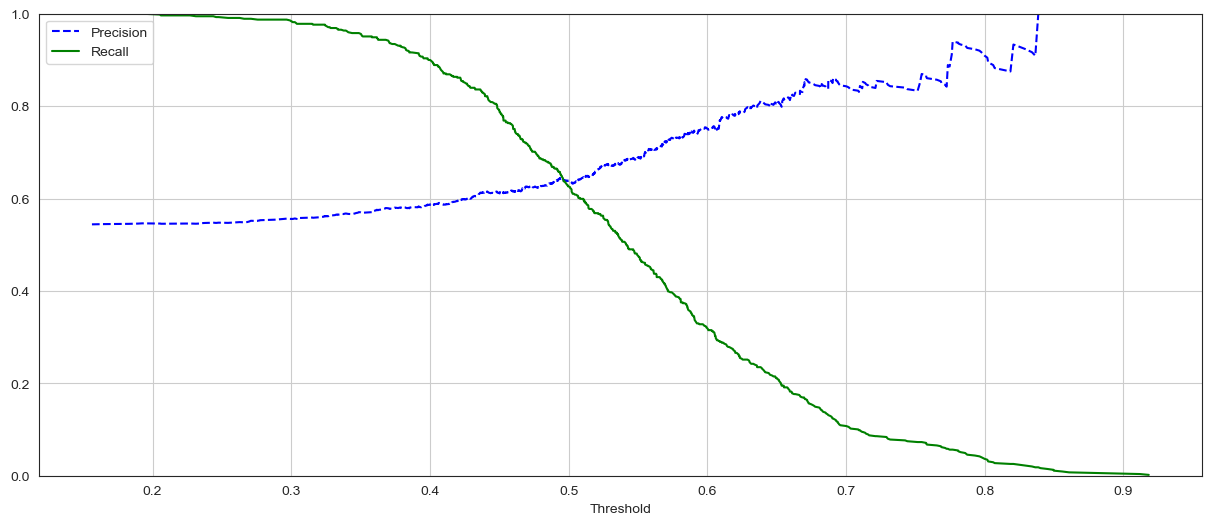

In [50]:
y_proba_lg_top = pipeline_lg_top.predict_proba(X_test_top)
y_proba_win_lg_top = y_proba_lg_top[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_win_lg_top)

plt.figure(figsize=(15, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0, 1])
plt.grid()
plt.show()

Logistic Regression Test Top
Accuracy: 0.6075322101090188
Precision: 0.627287853577371
Recall: 0.6867030965391621
F1 score: 0.6556521739130434
ROC AUC: 0.5998732874000158


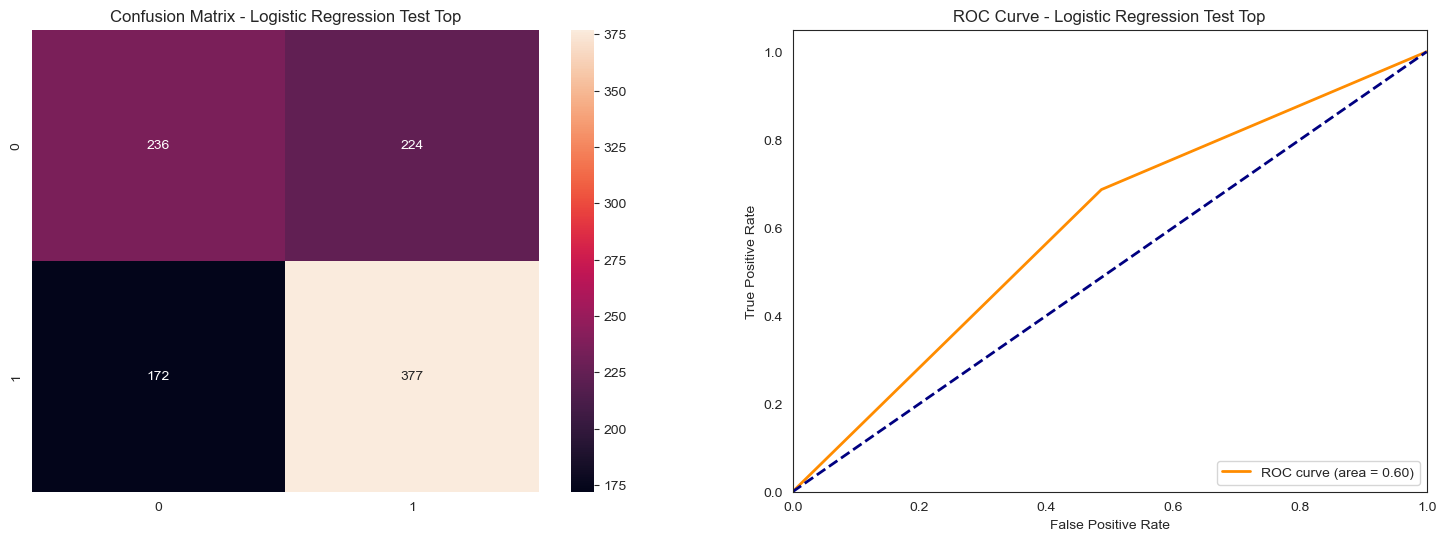

In [51]:
threshold = 0.48

y_pred = np.where(y_proba_win_lg_top >= threshold, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print('=' * 30)
print('Logistic Regression Test Top')
print('=' * 30)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')
print(f'ROC AUC: {auc_score}')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Confusion Matrix - Logistic Regression Test Top')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Logistic Regression Test Top')
axes[1].legend(loc="lower right")

plt.show()

In [52]:
score_dict['model'].append('Logistic Regression Top')
score_dict['accuracy'].append(accuracy)
score_dict['precision'].append(precision)
score_dict['recall'].append(recall)
score_dict['f1_score'].append(f1)
score_dict['roc_auc'].append(auc_score)
score_dict['threshold'].append(threshold)

### SVM Top

In [53]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_top),
        ('cat', categorical_transformer, categorical_features_top)
    ])

pipeline_svc_top = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=17))
])

pipeline_svc_top.fit(X_train_top, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['win_visiting_team',
                                                   'win_home_team', 'draw',
                                                   'h_goals_for_pctg',
                                                   'v_avg_road_goals_for',
                                                   'v_avg_road_goals_against',
                                                   'h_avg_home_goals_for',
                                                   'v_road_win_pctg',
                                                   'h_avg_home_goals_against',
                                                   'h_regulation_win_pctg',
                                                   'h_league_home_sequence',
                                                   'v_goals_for_pctg',
                                                   'h_home_win_p...
                                                   'v_home_goal_differential',
                                                   'v_win_pctg',
                                                   'h_l10_goals_against',
                                                   'v_goal_differential',
                                                   'h_goal_differential_pctg', ...]),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['season', 'home_team_code',
                                                   'visiting_team_code',
                                                   'h_division_name',
                                                   'h_streak_code',
                                                   'v_division_name',
                                                   'v_streak_code',
                                                   'game_month'])])),
                ('classifier', SVC(probability=True, random_state=17))])

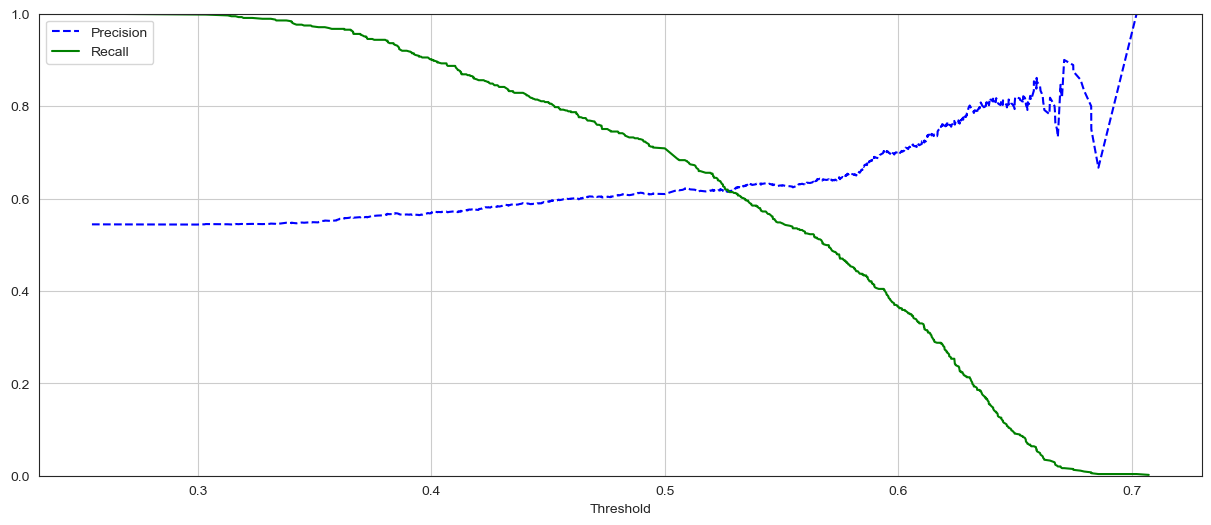

In [54]:
y_proba_svc_top = pipeline_svc_top.predict_proba(X_test_top)
y_proba_win_svc_top = y_proba_svc_top[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_win_svc_top)

plt.figure(figsize=(15, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0, 1])
plt.grid()
plt.show()

         SVM Test Top
Accuracy: 0.5916749256689792
Precision: 0.6179001721170396
Recall: 0.6539162112932605
F1 score: 0.6353982300884956
ROC AUC: 0.5856537578205433


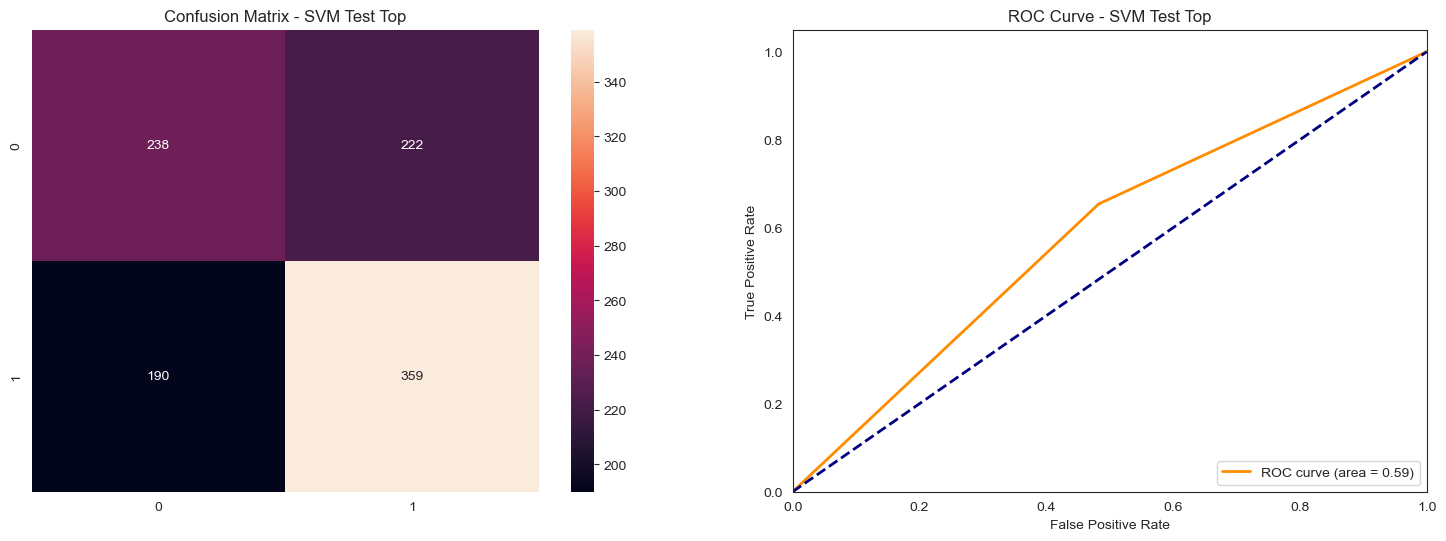

In [55]:
threshold = 0.52

y_pred = np.where(y_proba_win_svc_top >= threshold, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print('=' * 30)
print('         SVM Test Top')
print('=' * 30)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')
print(f'ROC AUC: {auc_score}')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Confusion Matrix - SVM Test Top')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - SVM Test Top')
axes[1].legend(loc="lower right")

plt.show()

In [56]:
score_dict['model'].append('SVC Top')
score_dict['accuracy'].append(accuracy)
score_dict['precision'].append(precision)
score_dict['recall'].append(recall)
score_dict['f1_score'].append(f1)
score_dict['roc_auc'].append(auc_score)
score_dict['threshold'].append(threshold)

### CatBoost Classifier Top

In [57]:
catboost_cl_top = CatBoostClassifier(
    iterations=5000,
    random_state=17,
    learning_rate=0.005,
    depth=6,
    l2_leaf_reg=7,
    cat_features=categorical_features_top,
)

catboost_cl_top.fit(X_train_top, y_train, verbose=500)

0:	learn: 0.6928943	total: 18.4ms	remaining: 1m 32s
500:	learn: 0.6591811	total: 6.6s	remaining: 59.2s
1000:	learn: 0.6494122	total: 13.3s	remaining: 53.3s
1500:	learn: 0.6407990	total: 20s	remaining: 46.5s
2000:	learn: 0.6297643	total: 26.6s	remaining: 39.9s
2500:	learn: 0.6164660	total: 33.4s	remaining: 33.3s
3000:	learn: 0.6041459	total: 40.2s	remaining: 26.8s
3500:	learn: 0.5930561	total: 47s	remaining: 20.1s
4000:	learn: 0.5825588	total: 53.7s	remaining: 13.4s
4500:	learn: 0.5726651	total: 1m	remaining: 6.71s
4999:	learn: 0.5636253	total: 1m 7s	remaining: 0us


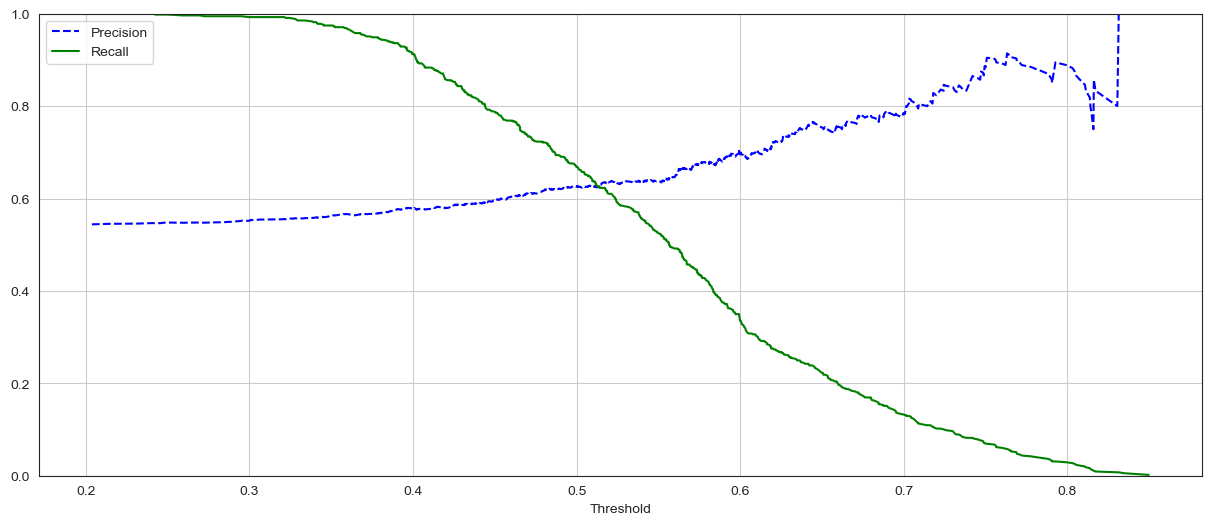

In [58]:
y_proba_catboost_top = catboost_cl_top.predict_proba(X_test_top)
y_proba_win_catboost_top = y_proba_catboost_top[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_win_catboost_top)

plt.figure(figsize=(15, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0, 1])
plt.grid()
plt.show()

CatBoost Classifier Test Top
Accuracy: 0.6055500495540139
Precision: 0.6177847113884556
Recall: 0.7213114754098361
F1 score: 0.665546218487395
ROC AUC: 0.5943513898788311


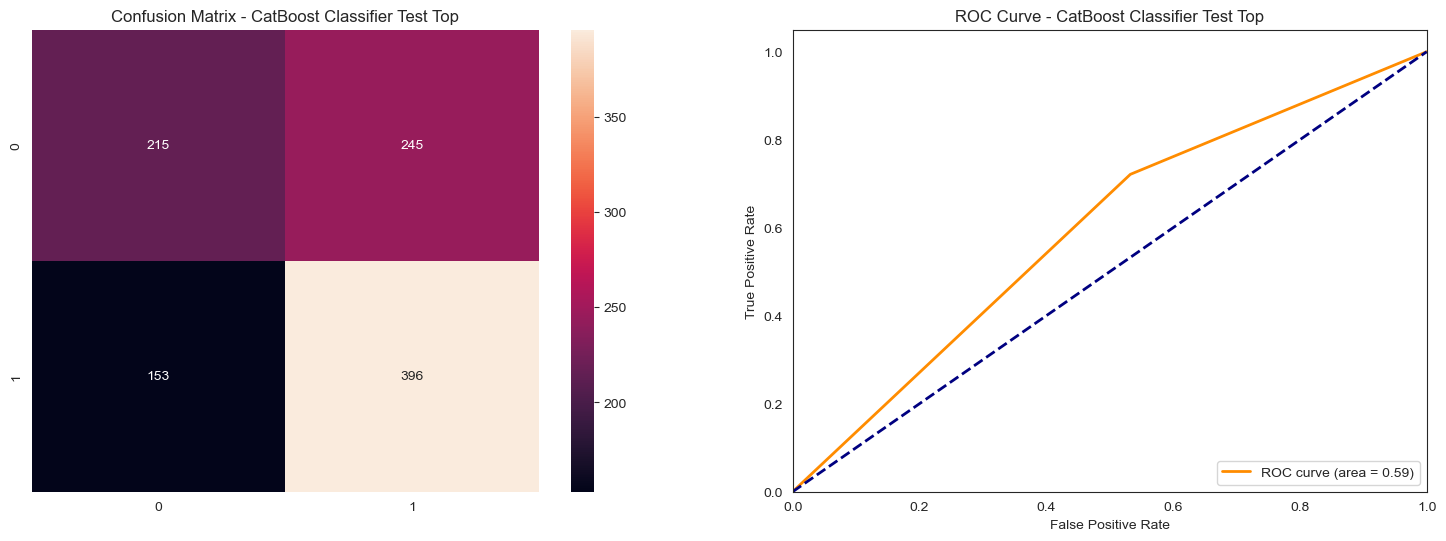

In [59]:
threshold = 0.48

y_pred = np.where(y_proba_win_catboost_top >= threshold, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print('=' * 30)
print('CatBoost Classifier Test Top')
print('=' * 30)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')
print(f'ROC AUC: {auc_score}')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Confusion Matrix - CatBoost Classifier Test Top')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - CatBoost Classifier Test Top')
axes[1].legend(loc="lower right")

plt.show()

In [60]:
score_dict['model'].append('CatBoost Classifier Top')
score_dict['accuracy'].append(accuracy)
score_dict['precision'].append(precision)
score_dict['recall'].append(recall)
score_dict['f1_score'].append(f1)
score_dict['roc_auc'].append(auc_score)
score_dict['threshold'].append(threshold)

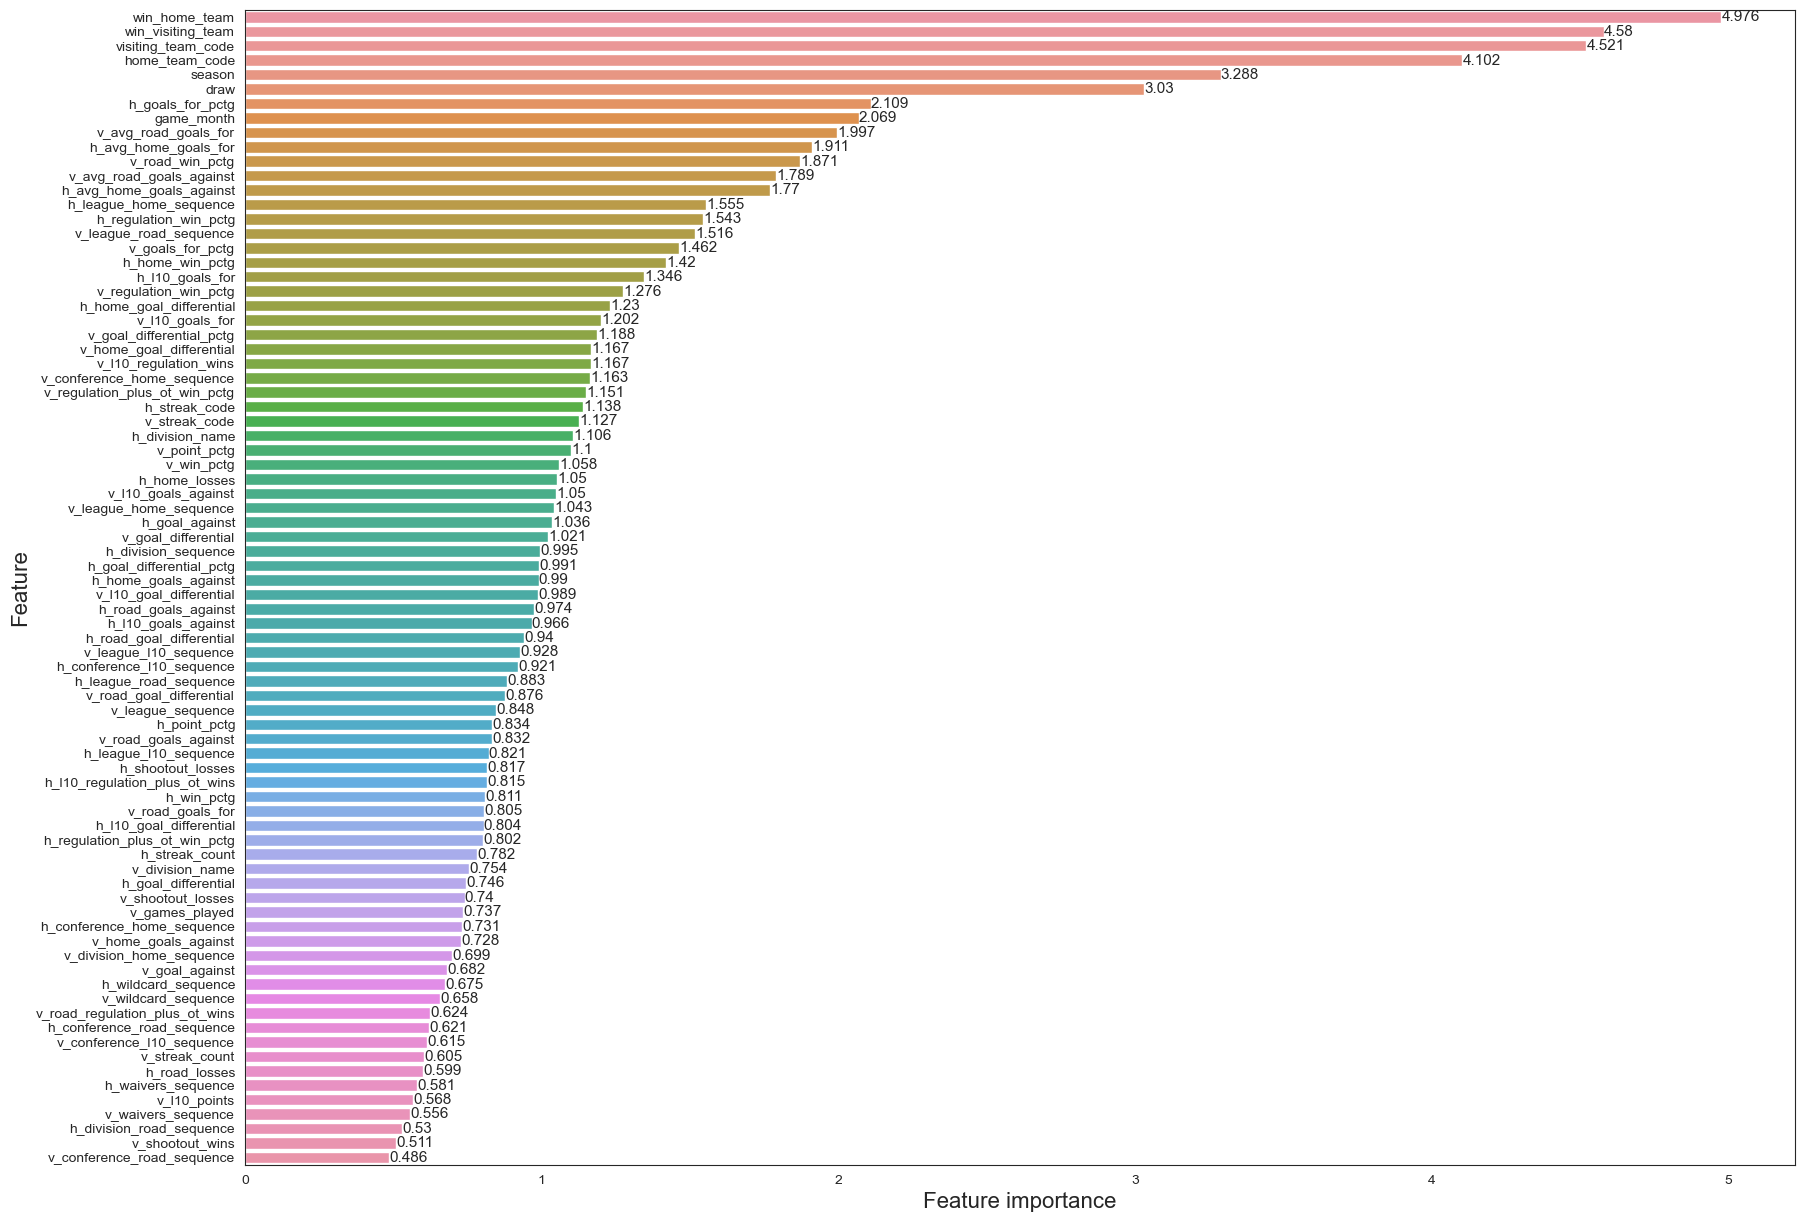

In [61]:
catboost_cl_top_importance = plot_feature_importance(catboost_cl_top, X_train_top, (20, 15))

### Сравним результаты

In [62]:
results = pd.DataFrame(score_dict).drop_duplicates()
results.sort_values(by='f1_score', ascending=False)

,model,accuracy,precision,recall,f1_score,roc_auc,threshold
6,CatBoost Classifier Top,0.605550,0.617785,0.721311,0.665546,0.594351,0.48
4,Logistic Regression Top,0.607532,0.627288,0.686703,0.655652,0.599873,0.48
1,Logistic Regression,0.610505,0.643382,0.637523,0.640439,0.607892,0.50
3,CatBoost Classifier,0.596630,0.624126,0.650273,0.636931,0.591441,0.50
5,SVC Top,0.591675,0.617900,0.653916,0.635398,0.585654,0.52
2,SVC,0.588702,0.618794,0.635701,0.627134,0.584155,0.52
0,Baseline - Random,0.483647,0.526316,0.510018,0.518039,0.481096,NaN


## Baseline - Bookmaker Odds
В качестве второго бейзлайна возьмем коэффициенты букмейкеров

In [63]:
y_proba_win_odds = 1 - X_test['win_home_team'] / (X_test['win_home_team'] + X_test['win_visiting_team'])

  Baseline - Bookmaker Odds
Accuracy: 0.6124876114965312
Precision: 0.6270096463022508
Recall: 0.7103825136612022
F1 score: 0.6660973526900085
ROC AUC: 0.6030173437871228


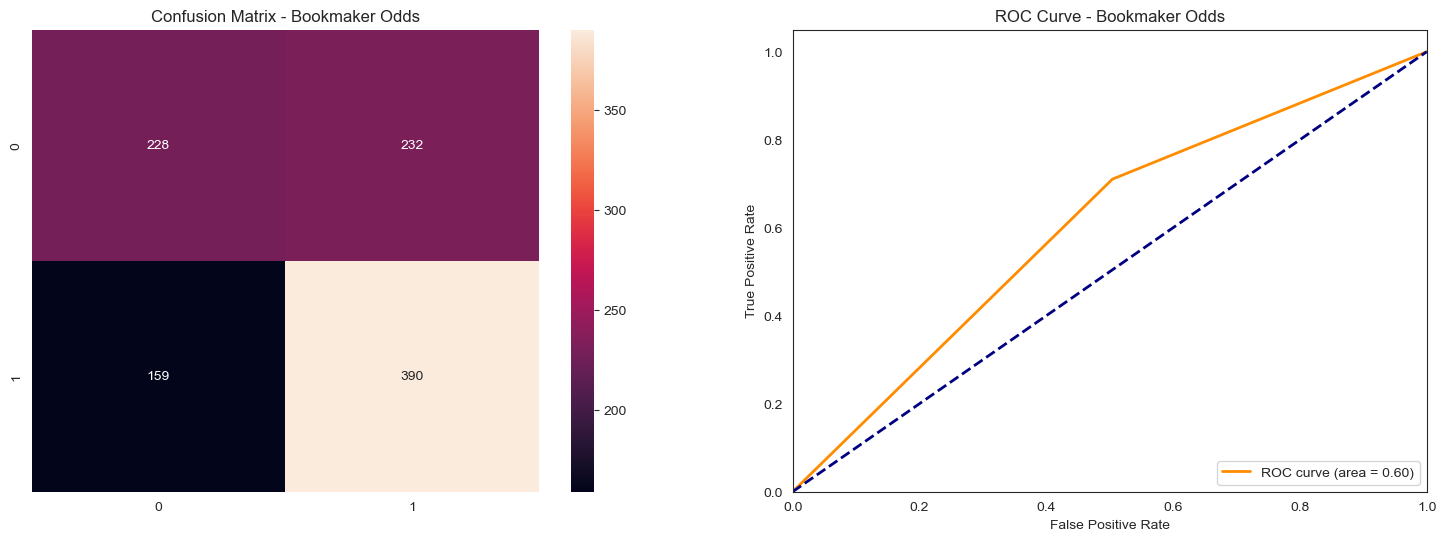

In [64]:
threshold = 0.5

y_pred = np.where(y_proba_win_odds >= threshold, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print('=' * 30)
print('  Baseline - Bookmaker Odds')
print('=' * 30)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')
print(f'ROC AUC: {auc_score}')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Confusion Matrix - Bookmaker Odds')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Bookmaker Odds')
axes[1].legend(loc="lower right")

plt.show()

In [65]:
score_dict['model'].append('Baseline - Bookmaker Odds')
score_dict['accuracy'].append(accuracy)
score_dict['precision'].append(precision)
score_dict['recall'].append(recall)
score_dict['f1_score'].append(f1)
score_dict['roc_auc'].append(auc_score)
score_dict['threshold'].append(threshold)

### Сравним результаты

In [66]:
results = pd.DataFrame(score_dict).drop_duplicates()
results.sort_values(by='f1_score', ascending=False)

,model,accuracy,precision,recall,f1_score,roc_auc,threshold
7,Baseline - Bookmaker Odds,0.612488,0.627010,0.710383,0.666097,0.603017,0.50
6,CatBoost Classifier Top,0.605550,0.617785,0.721311,0.665546,0.594351,0.48
4,Logistic Regression Top,0.607532,0.627288,0.686703,0.655652,0.599873,0.48
1,Logistic Regression,0.610505,0.643382,0.637523,0.640439,0.607892,0.50
3,CatBoost Classifier,0.596630,0.624126,0.650273,0.636931,0.591441,0.50
5,SVC Top,0.591675,0.617900,0.653916,0.635398,0.585654,0.52
2,SVC,0.588702,0.618794,0.635701,0.627134,0.584155,0.52
0,Baseline - Random,0.483647,0.526316,0.510018,0.518039,0.481096,NaN
